In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.fft import fftn, ifftn, fftshift, ifftshift, fft, ifft
from scipy.spatial.transform import Rotation

import cdiutils
cdiutils.plot.update_plot_params()

# pynx.scattering utilities
from pynx.scattering.fhkl import Fhkl_thread
from pynx.scattering.fthomson import f_thomson

### import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.fft import fftn, ifftn, fftshift, ifftshift, fft, ifft
from scipy.spatial.transform import Rotation

import cdiutils
cdiutils.plot.update_plot_params()

# pynx.scattering utilities
from pynx.scattering.fhkl import Fhkl_thread
from pynx.scattering.fthomson import f_thomson

#### We need to add all the functions related to simulations in `cdiutils.simulations` submodule

In [2]:
def read_lammps_positions(
        file_path: str,
        separate_atoms: bool = False,
        centre: bool =True
) -> np.ndarray | dict:
    """
    Reads atom positions from a LAMMPS .xyz or .lmp (dump) file.

    Args:
        file_path (str): path to the input file.
        separate_atoms (bool, optional): if True, separates positions by
            atom type. If False, returns all positions in one array.
            Defaults to False.

    Returns:
        dict or np.ndarray:
            - If separate_atoms=True, returns a dictionary {atom_type:
                positions_array}.
            - If separate_atoms=False, returns a single array of all
            positions.

    Raises:
        ValueError: if the file type cannot be detected or the file
            cannot be parsed.
    """
    # initialise storage for positions and atom types
    positions = []
    atom_types = []

    with open(file_path, 'r') as file:
        if file_path.endswith("xyz"):
            # Parse .xyz file
            file.readline()  # nb of atoms
            file.readline()  # comment line
            
            # parse atom positions
            for line in file:
                split_line = line.strip().split()
                atom_type = split_line[0]  # Atom type is the first column
                position = list(map(float, split_line[1:4]))  # x, y, z pos
                atom_types.append(atom_type)
                positions.append(position)

        elif file_path.endswith("lmp"):
            pass

    # convert to arrays
    positions = np.array(positions)
    print(positions.shape)
    atom_types = atom_types

    # Atom should centred with respect to the centroid of ALL atoms
    if centre:
        positions -= np.mean(positions, axis=0, keepdims=True)

    if separate_atoms:
        # group positions by atom type
        separated_positions = {atom_type: [] for atom_type in atom_types}
        for atom_type, position in zip(atom_types, positions):
            separated_positions[atom_type].append(position)

        # convert lists to arrays
        for atom_type in separated_positions:
            separated_positions[atom_type] = np.array(
                separated_positions[atom_type]
            ).T
            # print(np.mean(separated_positions[atom_type], axis=1))
            # separated_positions[atom_type] -= np.mean(
            #     separated_positions[atom_type], axis=1, keepdims=True
            # )

        return dict(separated_positions)
    else:
        # return all positions in a single array
        return positions


In [3]:
# size = 200

# path = (
#     "/data/id01/inhouse/corentin/lammps/Ni3Fe/meam_Choi2018/CS_Ni3Fe_exp_"
#     f"{size}/CS_Ni3Fe_exp_size_{size}_minimized.xyz"
# )

# path = (
#     "/data/id01/inhouse/corentin/lammps/Ni3Fe/meam_Choi2018/"
#     f"NP_coreshell_{size}_0.2_0.9_shape_exp/"
#     f"CS_Ni3Fe_{size}_0.2_0.9_minimized_shape_exp.xyz"
# )

size = 500

path = (
    "/data/id01/inhouse/corentin/lammps/Ni3Fe/meam_Choi2018/"
    f"NP_coreshell_{size}_0.2_0.9_shape_exp/"
    f"CS_Ni3Fe_{size}_0.2_0.9_minimized_shape_exp.xyz"
)

positions = read_lammps_positions(path, separate_atoms=True, centre=True)  # Do not forget to centre !!
Fe_positions = positions["1"]
Ni_positions = positions["2"]
print(
    f"Number of Fe atoms: {Fe_positions.shape[1]}.\n"
    f"Number of Ni atoms: {Ni_positions.shape[1]}.\n"
    f"Total number of atoms: {Fe_positions.shape[1] + Ni_positions.shape[1]}."
)


(36641942, 3)
Number of Fe atoms: 4101978.
Number of Ni atoms: 32539964.
Total number of atoms: 36641942.


### Same as above just bigger elements for paper legibility

#### Some parameters
- Here we are going to simulate an X-ray scattering experiment. For that we need to define where we are going to look at in the reciprocal space. Therefore, we need:
    * a Bragg reflection (`hkl`)
    * a lattice parameter

- We also need to specify how fine we want our reciprocal space grid to be. This is basically defined by:
    * the number of steps (`step_nb`), the higher the better the resolution, oversampling
    * the reciprocal space resolution (`dq`)
    * the lattice parameter

#### Rotate a [111]-oriented vector so it aligns to the z-axis
Instead of rotating the crystal, we can simply look at where we expect the **111** Bragg peak of the un-rotated crystal to diffract in the ($x$, $y$, $z$) frame. It's basically the reverse of the above operation.

In [4]:
hkl = [1, 1, 1]
original_vector = np.array(hkl) / np.linalg.norm(hkl)
target_vector = np.array([0, 0, 1], dtype=float)
target_vector /= np.linalg.norm(target_vector)

rotation_axis = np.cross(original_vector, target_vector)
rotation_axis /= np.linalg.norm(rotation_axis)
angle = np.arccos(np.dot(original_vector, target_vector)) 

rotation = Rotation.from_rotvec(angle * rotation_axis)
rotated_hkl = rotation.apply(np.column_stack(hkl))

# extract rotated x, y, z arrays
rotated_hkl = rotated_hkl.T

In [5]:
all_positions = np.concatenate((Fe_positions, Ni_positions), axis=1)
all_positions.shape

(3, 36641942)

In [6]:
# # Simple bounding-box diameter (fast, works for any shape)
# all_xyz = np.hstack([Fe_positions, Ni_positions]).T  # (N,3)
# mins = all_xyz.min(0); maxs = all_xyz.max(0)
# Lx, Ly, Lz = (maxs - mins)
# bbox_diam = max(Lx, Ly, Lz)          # “largest linear size” through the cloud
# bbox_avg  = (Lx + Ly + Lz) / 3       # average extent (optional)
# print(f"Lx={Lx:.3f}, Ly={Ly:.3f}, Lz={Lz:.3f} (input units)")


In [7]:
# # Core–shell specific: core radius & shell thickness
# # distances from centroid
# r = np.linalg.norm(np.hstack([Fe_positions, Ni_positions]), axis=0)
# r_Fe = np.linalg.norm(Fe_positions, axis=0)
# r_Ni = np.linalg.norm(Ni_positions, axis=0)

# core_r  = np.percentile(r_Fe, 95)      # Fe core ~95th percentile
# shell_r = np.percentile(r_Ni, 95)      # Ni shell outer radius
# thick   = shell_r - core_r
# print(f"Core radius ≈ {core_r:.3f}, Outer radius ≈ {shell_r:.3f}, Shell thickness ≈ {thick:.3f} (input units)")


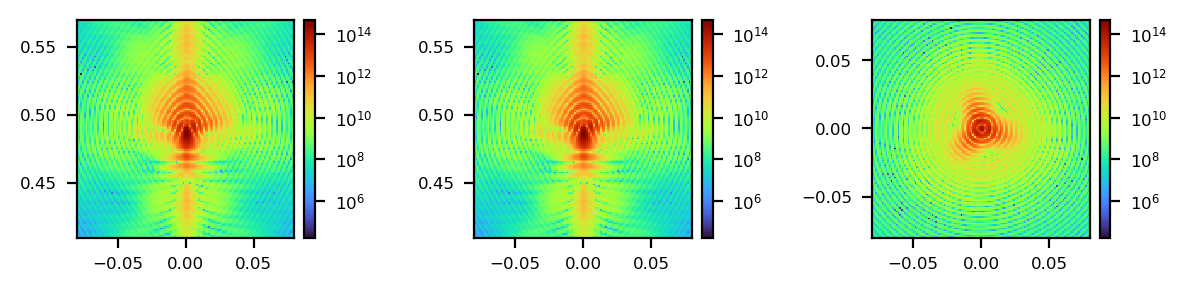

Elapsed time for the scattering computation: 693.8150796890259 s
Spatial resolution in the direct space:  2.227703155803243 2.227703155803243 2.2277031558032423 nm


In [6]:
lattice_parameter = 3.536478759837648
d_spacing = lattice_parameter / np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)

step_nb = 800 # Using 800 makes the concentration calculation plot become like 3x3???
# step_nb = 400
dq = np.array([1, 1, 1]) / step_nb

# q_size = (256, 256, 256)
q_size = (128, 128, 128)
# q_size = (64, 64, 64)

# Let us build the reciprocal space grid
q_ranges = []
for i in range(3):
    q_ranges.append(
        # (hkl[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i])
        (rotated_hkl[i] + (np.arange(q_size[i]) - (q_size[i] / 2)) * dq[i])
        / lattice_parameter
    )
qx, qy, qz = np.meshgrid(*q_ranges, indexing="ij")

# Here is where the magic happens
scattered_amp, dt = Fhkl_thread(
    qx, qy, qz,
    *all_positions,
    occ=None,
    gpu_name="",
    language="cuda"
)

"""Don't need to always run this test plot of scattering"""

diff_pattern = np.abs(scattered_amp)**2

cdiutils.plot.plot_volume_slices(
    diff_pattern, norm=LogNorm(),
    voxel_size=(dq[0], dq[1], dq[2]),
    data_centre=(np.mean(qx), np.mean(qy), np.mean(qz)),
    convention="xu",
    # integrate=True
)

print(
    f"Elapsed time for the scattering computation: {dt} s\n"
    "Spatial resolution in the direct space: ",
    1 / np.ptp(qx) * .1, 1 / np.ptp(qy) * .1, 1 / np.ptp(qz) * .1, "nm"
)

### Adding [hkl] to diffraction pattern

### Accounting for the scattering factors $f'$ and $f''$
We first load the scattering factors

In [7]:
!tree -L 2 /data/id01/inhouse/tsarrazin/simulation/atomic_scattering_factors/

/data/id01/inhouse/tsarrazin/simulation/atomic_scattering_factors/
├── Hephaestus
│   ├── Iron.f1f2
│   └── Nickel.f1f2
└── Ni_atomic_scattering_factors.txt

1 directory, 3 files


Text(0.5, 1.0, 'Ni')

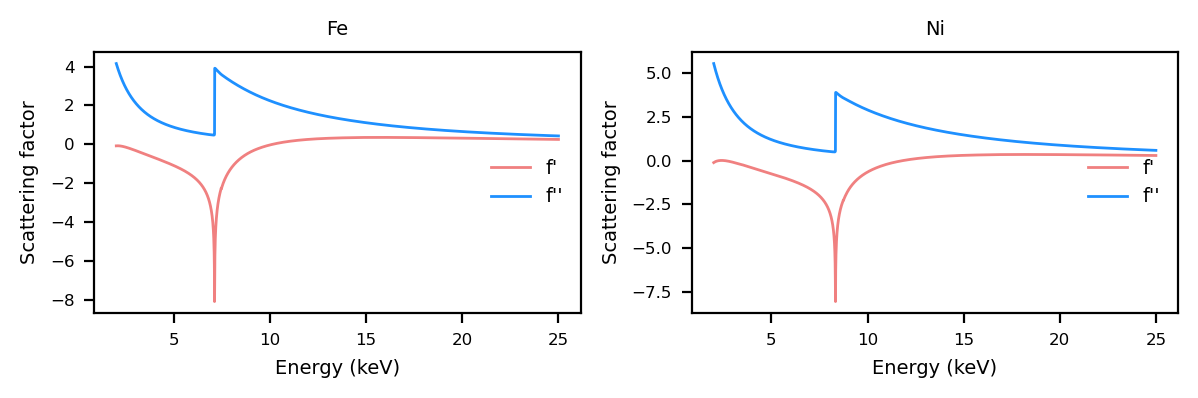

In [8]:
scattering_factor_dir = (
    "/data/id01/inhouse/tsarrazin/simulation/atomic_scattering_factors/"
    "Hephaestus/"
)
Fe_data = np.loadtxt(
    scattering_factor_dir + "Iron.f1f2", skiprows=4,
    usecols=(0, 1, 2), unpack=True,
)
Ni_data =  np.loadtxt(
    scattering_factor_dir + "Nickel.f1f2", skiprows=4,
    usecols=(0, 1, 2), unpack=True,
)

# Put everything in a dict
scat_factors = {"Fe": {}, "Ni": {}}
for atom, data in zip(("Fe", "Ni"), (Fe_data, Ni_data)):
    scat_factors[atom]["energy"] = data[0]
    scat_factors[atom]["f1"] = data[1]
    scat_factors[atom]["f2"] = data[2]

# Plot the data
fig, axes= plt.subplots(1, 2, layout="tight", figsize=(6, 2))
for ax, atom in zip(axes.flat, ("Fe", "Ni")):
    energy = scat_factors[atom]["energy"]* 1e-3
    ax.plot(energy, scat_factors[atom]["f1"], c="lightcoral", label="f'")
    ax.plot(energy, scat_factors[atom]["f2"], c="dodgerblue", label="f''")
    ax.legend(frameon=False, loc='center right')
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Scattering factor")
axes[0].set_title("Fe")
axes[1].set_title("Ni")

#### Let's interpolate the data so we are not limited to specific energies

In [9]:
from scipy.interpolate import interp1d, CubicSpline

def interpolate_factors(
        energy: np.ndarray,
        f1: np.ndarray,
        f2: np.ndarray,
        method="cubic",
        **kwargs,
) -> tuple[callable, callable]:
    """
    Interpolates the scattering factors f' and f'' for a given target
    energy.

    Parameters:
        energy (ndarray): 1D array of energy values.
        f1 (ndarray): 1D array of f' values corresponding to the energies.
        f2 (ndarray): 1D array of f'' values corresponding to the energies.
        method (str, optional): Interpolation method, "linear" or
            "cubic" Defaults to "cubic".

    Returns:
        tuple: Interpolated (f', f'') values for the target energy.
    """
    # Ensure the energy array is sorted
    sorted_indices = np.argsort(energy)
    energy_sorted = energy[sorted_indices]
    f1_sorted = f1[sorted_indices]
    f2_sorted = f2[sorted_indices]

    # Check interpolation method
    if method == "linear":
        f1_interp = interp1d(
            energy_sorted, f1_sorted, kind='linear', fill_value="extrapolate"
        )
        f2_interp = interp1d(
            energy_sorted, f2_sorted, kind='linear', fill_value="extrapolate"
        )
    elif method == "cubic":
        f1_interp = CubicSpline(energy_sorted, f1_sorted)
        f2_interp = CubicSpline(energy_sorted, f2_sorted)
    else:
        raise ValueError(
            "Unsupported interpolation method. Use 'linear' or 'cubic'."
        )
    return f1_interp, f2_interp


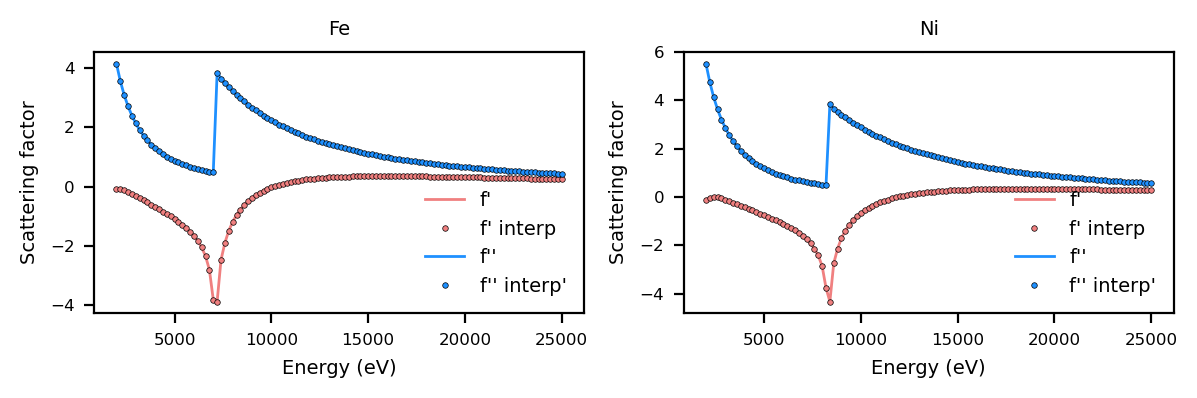

In [10]:
# Interpolate the factors
scat_factors["Fe"]["f1_interp"], scat_factors["Fe"]["f2_interp"] = (
    interpolate_factors(**scat_factors["Fe"], method="cubic")
)
scat_factors["Ni"]["f1_interp"], scat_factors["Ni"]["f2_interp"] = (
    interpolate_factors(**scat_factors["Ni"], method="cubic")
)

# Plot the data
fig, axes= plt.subplots(1, 2, layout="tight", figsize=(6, 2))
params = {
    "marker": "o", "lw": 0, "ms": 2,
    "markeredgecolor": "k", "markeredgewidth": 0.25,
}
for ax, atom in zip(axes.flat, ("Fe", "Ni")):
    
    the_slice = slice(None, None, 40)
    
    energy = scat_factors[atom]["energy"][the_slice]  # To enhance readability
    
    ax.plot(
        energy, scat_factors[atom]["f1"][the_slice], c="lightcoral", label="f'"
    )
    params.update({"label": "f' interp", "c": "lightcoral"})
    ax.plot(energy, scat_factors[atom]["f1_interp"](energy), **params)

    ax.plot(
        energy, scat_factors[atom]["f2"][the_slice], c="dodgerblue", label="f''"
    )
    params.update({"label": "f'' interp'", "c": "dodgerblue"})
    ax.plot(energy, scat_factors[atom]["f2_interp"](energy), **params)
    
    ax.legend(frameon=False, loc='lower right')
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Scattering factor")
    ax.set_title(atom);

#### Make the full scattering factor function

In [11]:
s = 1 / (2 * d_spacing)

scat_factors["Fe"]["full"] = lambda x: (
    f_thomson(s, "Fe")
    + scat_factors["Fe"]["f1_interp"](x)
    + 1j * scat_factors["Fe"]["f2_interp"](x)
)
scat_factors["Ni"]["full"] = lambda x: (
    f_thomson(s, "Ni")
    + scat_factors["Ni"]["f1_interp"](x)
    + 1j * scat_factors["Ni"]["f2_interp"](x)
)

# Check the factors at the energy k-edge
# scat_factors["Fe"]["full"](7112.0),
# scat_factors["Ni"]["full"](8332.8), scat_factors["Fe"]["full"](8332.8)
print(scat_factors["Ni"]["full"](8333), scat_factors["Fe"]["full"](8333))
print(scat_factors["Ni"]["f1_interp"](8333))
print(type(scat_factors["Ni"]["f1_interp"](8333)))

(12.43101469841726+2.5765144452983755j) (17.70073542472576+3.0252748056953864j)
-8.142993059876163
<class 'numpy.ndarray'>


#### Simulate the Fhkl for both atom types

Let's first define a generic function that handles the energy-dependent scattering calculations. The function can accept an arbitraty number of atom types. 

In [12]:
shape = qx.shape

In [13]:
def energy_dependent_scattered_amp(
        qx, qy, qz : np.ndarray,
        *atom_positions_and_factors: tuple,
        energy: float
) -> tuple[np.ndarray]:
    """
    Calculate the energy-dependent scattering amplitude for an arbitrary
    number of atom types.

    Args:
        qx, qy, qz (np.ndarray): Reciprocal space grid components.
        *atom_positions_and_factors (tuples): 
            - Variable-length arguments.
            - Each argument is a tuple (positions, scattering_function).
            - Positions are (x, y, z) arrays.
            - Scattering_function is a callable that depends on energy.
        energy (float): Energy value used to compute the scattering
            factor.

    Returns:
        np.ndarray: the full complex scattering amplitude.
    """
    
    # handle case when a single atom type is passed without being a
    # tuple
    if (
            len(atom_positions_and_factors) == 2
            and callable(atom_positions_and_factors[1])
    ):
        # single atom type case
        atom_positions_and_factors = [atom_positions_and_factors]

    # initialize amplitudes array for all atom types
    amplitudes = np.zeros(
        (len(atom_positions_and_factors), ) + shape, dtype=np.complex128
    )    
    # Loop over atom types
    for i, (positions, f_factor) in enumerate(atom_positions_and_factors):
        if (
                not isinstance(positions, (tuple, list, np.ndarray))
                or len(positions) != 3
        ):
            raise ValueError(
                "Positions must be a tuple or list of three arrays (x, y, z)."
            )
        
        # Compute amplitude for the given atom type
        amplitudes[i], _ = Fhkl_thread(
            qx, qy, qz,
            *positions,
            occ=None,
            gpu_name="",
            language="cuda"
        )

        # energy-dependent scattering factor
        amplitudes[i] = amplitudes[i] * f_factor(energy)
    
    return amplitudes[0] + amplitudes[1]

    # return amplitudes.sum(axis=0)


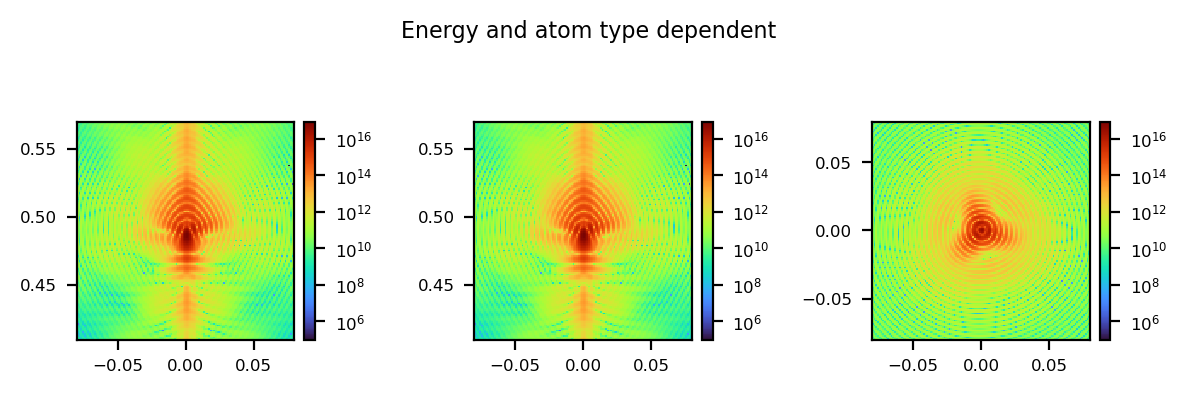

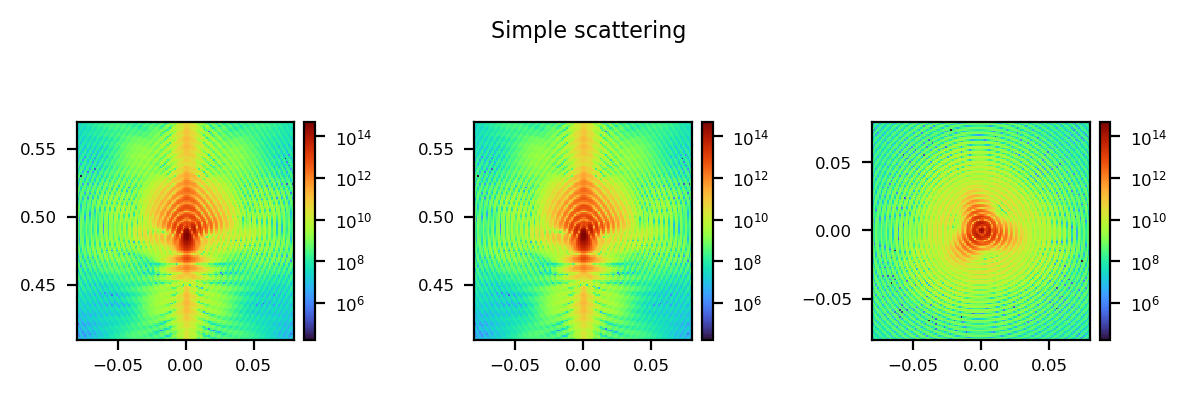

(<Figure size 1200x400 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [14]:
energy = 8332.8  # Ni K-edge
# energy = 7112.0 - 10 # Fe K-dege
# Thomas_BiWeekly_15-01-25
full_scattered_amp = energy_dependent_scattered_amp(
    qx, qy, qz,
    (Fe_positions, scat_factors["Fe"]["full"]),
    (Ni_positions, scat_factors["Ni"]["full"]),
    energy=energy
)
full_diff_pattern = np.abs(full_scattered_amp)**2

plot_params = {
    "voxel_size": (dq[0], dq[1], dq[2]), "convention": "xu",
    "data_centre":(np.mean(qx), np.mean(qy), np.mean(qz)),
}
cdiutils.plot.plot_volume_slices(
    full_diff_pattern, norm=LogNorm(), title="Energy and atom type dependent",
    **plot_params
)
cdiutils.plot.plot_volume_slices(
    diff_pattern, norm=LogNorm(), title="Simple scattering", **plot_params
)

### Adding [hkl] to diffraction pattern

In [17]:
print(f"dq type and shape: {type(dq)} and {dq.shape}")
print(f"q_size type: {type(q_size)} and has no shape because it's a tuple")
print(f"q_ranges type and shape: {type(q_ranges)} and has no shape because it's a list")
print(f"diff_pattern type and shape: {type(diff_pattern)} and {diff_pattern.shape}")

dq type and shape: <class 'numpy.ndarray'> and (3,)
q_size type: <class 'tuple'> and has no shape because it's a tuple
q_ranges type and shape: <class 'list'> and has no shape because it's a list
diff_pattern type and shape: <class 'numpy.ndarray'> and (128, 128, 128)


In [18]:
# # import numpy as np

# def _as_3d(qx, qy, qz):
#     """Accept 1D axes or 3D grids and return 3D grids with ij indexing."""
#     if qx.ndim == qy.ndim == qz.ndim == 1:
#         return np.meshgrid(qx, qy, qz, indexing='ij')
#     return qx, qy, qz

# def hkl_grid_from_q(qx, qy, qz, hkl0=(1,1,1), *,
#                     units="rlu",
#                     a=None, b=None, c=None):
#     """
#     Map q-grid to HKL about a chosen Bragg peak.
#     Parameters
#     ----------
#     qx,qy,qz : 1D axes or 3D grids for the q offsets (centered at 0).
#     hkl0     : tuple/list of (h0,k0,l0) for the Bragg peak (e.g. (1,1,1)).
#     units    : "rlu" or "invA".
#     a,b,c    : real-space lattice vectors (Å) as 3-vectors if units="invA".
#                For cubic: a=(a0,0,0), b=(0,a0,0), c=(0,0,a0).
#     Returns
#     -------
#     H,K,L : 3D arrays (same shape as q-grid).
#     """
#     qx3, qy3, qz3 = _as_3d(qx, qy, qz)

#     if units == "rlu":
#         dH, dK, dL = qx3, qy3, qz3

#     elif units == "invA":
#         if any(v is None for v in (a,b,c)):
#             raise ValueError("For units='invA', provide real-space a,b,c vectors in Å.")
#         a = np.asarray(a, float); b = np.asarray(b, float); c = np.asarray(c, float)
#         # stack q into last axis to do the dot products efficiently
#         q = np.stack([qx3, qy3, qz3], axis=-1)  # (..., 3)
#         # Δh = (q·a)/(2π), etc.
#         twopi = 2*np.pi
#         dH = (q @ a) / twopi
#         dK = (q @ b) / twopi
#         dL = (q @ c) / twopi
#     else:
#         raise ValueError("units must be 'rlu' or 'invA'.")

#     h0,k0,l0 = hkl0
#     H = h0 + dH
#     K = k0 + dK
#     L = l0 + dL
#     return H, K, L

# def pack_intensity_hkl(diff_pattern, H, K, L, channel_first=True, dtype=np.float32):
#     """Pack intensity and HKL into a single array: shape (4, Z, Y, X) or (Z, Y, X, 4)."""
#     I = diff_pattern.astype(dtype, copy=False)
#     H = H.astype(dtype, copy=False)
#     K = K.astype(dtype, copy=False)
#     L = L.astype(dtype, copy=False)
#     if channel_first:
#         return np.stack([I, H, K, L], axis=0)
#     else:
#         return np.stack([I, H, K, L], axis=-1)

# # -------------------------
# # EXAMPLE USAGE
# # -------------------------

# diff_pattern = full_diff_pattern
# nqz, nqy, nqx = diff_pattern.shape

# dq = np.asarray(dq, dtype=float)  # e.g., dq = [dq_x, dq_y, dq_z]
# if dq.size == 1:
#     dq_x = dq_y = dq_z = float(dq)
# else:
#     dq_x, dq_y, dq_z = dq
    
# # from lower down nx, ny, nz = conc2.shape
# # 1) If your grid was built with dq = [1,1,1]/N (i.e. r.l.u.), and you have 1D axes:
# qx_axis = (np.arange(nqx) - nqx // 2) * dq_x
# qy_axis = (np.arange(nqy) - nqy // 2) * dq_y
# qz_axis = (np.arange(nqz) - nqz // 2) * dq_z
# # Then:
# H, K, L = hkl_grid_from_q(qx_axis, qy_axis, qz_axis, hkl0=(1,1,1), units="rlu")

# # 2) If your q is in 1/Å and cubic with lattice parameter a0 (Å):
# # a = (a0,0,0); b=(0,a0,0); c=(0,0,a0)
# # H, K, L = hkl_grid_from_q(qx_axis, qy_axis, qz_axis, hkl0=(1,1,1),
# #                           units="invA", a=a, b=b, c=c)

# # After you compute H,K,L, pack with intensity (diff_pattern is your |F|^2 volume):
# packed = pack_intensity_hkl(diff_pattern, H, K, L, channel_first=True)
# # Now `packed[0]` is intensity, `packed[1]`=H, `packed[2]`=K, `packed[3]`=L.

# print(f"packed type and shape: {type(packed)} and {packed.shape}")
# print(f"packed[:,0,0,0]{packed[:,0,0,0]}")
# print(f"packed[:,nqx//2,nqy//2,nqz//2]{packed[:,nqx//2,nqy//2,nqz//2]}")
# print(f"packed[:,nqx//2+5,nqy//2+5,nqz//2+5]{packed[:,nqx//2+5,nqy//2+5,nqz//2+5]}")

# For NanoMAD
### Creating 11 diffraction patterns with hkl 
### No Noise Yet

In [19]:
""""LAST RUN: 20/08/2025"""

# import os

# def _e_str(e):
#     # tidy energy for filename: 8332.8 -> "8332.8", 8333.0 -> "8333"
#     s = f"{float(e):.1f}".rstrip('0').rstrip('.')
#     return s

# dq = np.asarray(dq, dtype=float)  # e.g., dq = [dq_x, dq_y, dq_z]
# if dq.size == 1:
#     dq_x = dq_y = dq_z = float(dq)
# else:
#     dq_x, dq_y, dq_z = dq

# save_dir = '/data/id01/inhouse/tsarrazin/BCDI_reconstructions/BigParticle_simulations/Ni3Fe/11energies/noise_none'
# os.makedirs(save_dir, exist_ok=True)

# E0 = 8333 # Or should we use 8332.8?
# energies = E0-50, E0-20, E0-10, E0-5, E0-2, E0-1, E0, E0+1, E0+2, E0+5, E0+10

# for energy in energies:

#     full_scattered_amp = energy_dependent_scattered_amp(
#         qx, qy, qz,
#         (Fe_positions, scat_factors["Fe"]["full"]),
#         (Ni_positions, scat_factors["Ni"]["full"]),
#         energy=energy
#     )
#     full_diff_pattern = np.abs(full_scattered_amp)**2

#     # nqz, nqy, nqx = full_diff_pattern.shape
#     nqx, nqy, nqz = full_diff_pattern.shape

    
        
#     # from lower down nx, ny, nz = conc2.shape
#     # 1) If your grid was built with dq = [1,1,1]/N (i.e. r.l.u.), and you have 1D axes:
#     qx_axis = (np.arange(nqx) - nqx // 2) * dq_x
#     qy_axis = (np.arange(nqy) - nqy // 2) * dq_y
#     qz_axis = (np.arange(nqz) - nqz // 2) * dq_z
#     # Then:
#     H, K, L = hkl_grid_from_q(qx_axis, qy_axis, qz_axis, hkl0=(1,1,1), units="rlu")

#     # 2) If your q is in 1/Å and cubic with lattice parameter a0 (Å):
#     # a = (a0,0,0); b=(0,a0,0); c=(0,0,a0)
#     # H, K, L = hkl_grid_from_q(qx_axis, qy_axis, qz_axis, hkl0=(1,1,1),
#     #                           units="invA", a=a, b=b, c=c)

#     # After you compute H,K,L, pack with intensity (full_diff_pattern is your |F|^2 volume):
#     packed_diff_hkl = pack_intensity_hkl(full_diff_pattern, H, K, L, channel_first=True)
#     # Now `packed_diff_hkl[0]` is intensity, `packed_diff_hkl[1]`=H, `packed_diff_hkl[2]`=K, `packed_diff_hkl[3]`=L.

#     print(f"\n")
#     print(f"for packed_diff_hkl_{_e_str(energy)}:")
#     print(f"packed_diff_hkl type and shape: {type(packed_diff_hkl)} and {packed_diff_hkl.shape}")
#     print(f"packed_diff_hkl[:,0,0,0]{packed_diff_hkl[:,0,0,0]}")
#     print(f"packed_diff_hkl[:,nqx//2,nqy//2,nqz//2]{packed_diff_hkl[:,nqx//2,nqy//2,nqz//2]}")
#     print(f"packed_diff_hkl[:,nqx//2+5,nqy//2+5,nqz//2+5]{packed_diff_hkl[:,nqx//2+5,nqy//2+5,nqz//2+5]}")

#     out_path = os.path.join(save_dir, f"packed_diff_hkl_{_e_str(energy)}eV.npy")
#     np.save(out_path, packed_diff_hkl)
#     print("saved ->", out_path)

'"LAST RUN: 20/08/2025'

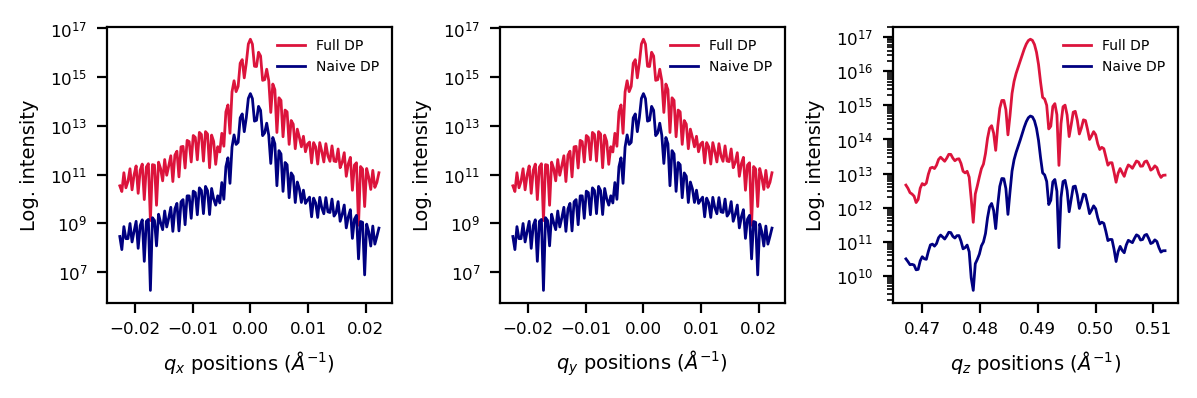

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2), layout="tight")
for i, (ax, q) in enumerate(zip(axes.flat, (qx, qy, qz))):
    slices = [slice(shape[k] // 2, shape[k] // 2+1, 1) for k in range(3)]
    slices[i] = slice(None)
    slices = tuple(slices)
    ax.plot(q[slices].ravel(), full_diff_pattern[slices].ravel(), c="crimson", label="Full DP")
    ax.plot(q[slices].ravel(), diff_pattern[slices].ravel(), c="navy", label="Naive DP")
    ax.set_yscale("log")
    ax.set_ylabel("Log. intensity")
    ax.legend(frameon=False, fontsize=5)

axes[0].set_xlabel(r"$q_x$ positions ($\AA ^{-1}$)")
axes[1].set_xlabel(r"$q_y$ positions ($\AA ^{-1}$)")
axes[2].set_xlabel(r"$q_z$ positions ($\AA ^{-1}$)");

### Pseudo-phase retrieval, direct space analysis
Obviously, this isn't phase retrieval as we will inverse Fourier transform the complex-valued amplitude. 

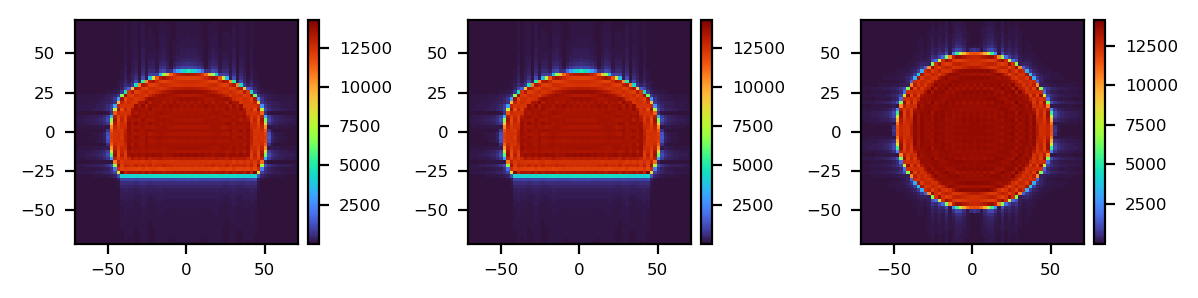

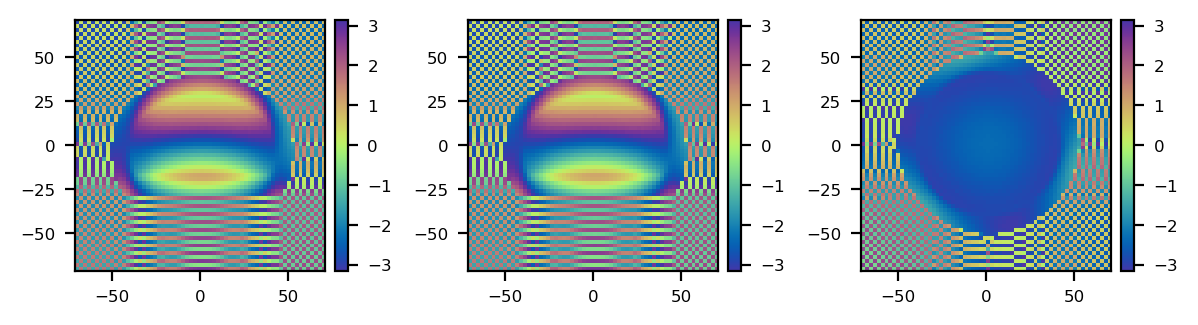

(<Figure size 1200x400 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [21]:
voxel_size = tuple(1e-1 / np.ptp(q) for q in (qx, qy, qz))  # in nm
obj = ifftshift(ifftn(fftshift(full_scattered_amp)))

support = cdiutils.utils.make_support(np.abs(obj), isosurface=0.75)
plot_params = {
    "support": support, "convention": "xu", "voxel_size": voxel_size,
    "data_centre": (0, 0, 0)
}
# cdiutils.plot.plot_volume_slices(np.abs(obj))
cdiutils.plot.plot_volume_slices(np.abs(obj), **plot_params)
cdiutils.plot.plot_volume_slices(
    np.angle(obj), cmap="cet_CET_C9s_r", vmin=-np.pi, vmax=np.pi, **plot_params
)

In [22]:
# Code from Ewen for Poisson noise

from scipy.fft import fftshift, ifftshift, fftn, ifftn

def create_diffracted_amplitude(obj):
    return ifftshift(fftn(fftshift(obj)))

def create_object(fexp):
    return ifftshift(ifftn(fftshift(fexp)))

def create_poisson_obj(obj, poisson_factor):
    amp = create_diffracted_amplitude(obj)
    data = np.abs(amp)**2.
    
    data_noise = np.random.poisson(poisson_factor*data/np.max(data))

    amp_noise = np.sqrt(data_noise) * np.exp(1.0j*np.angle(amp))
    obj_noise = create_object(amp_noise)
    
    return data, data_noise, obj_noise

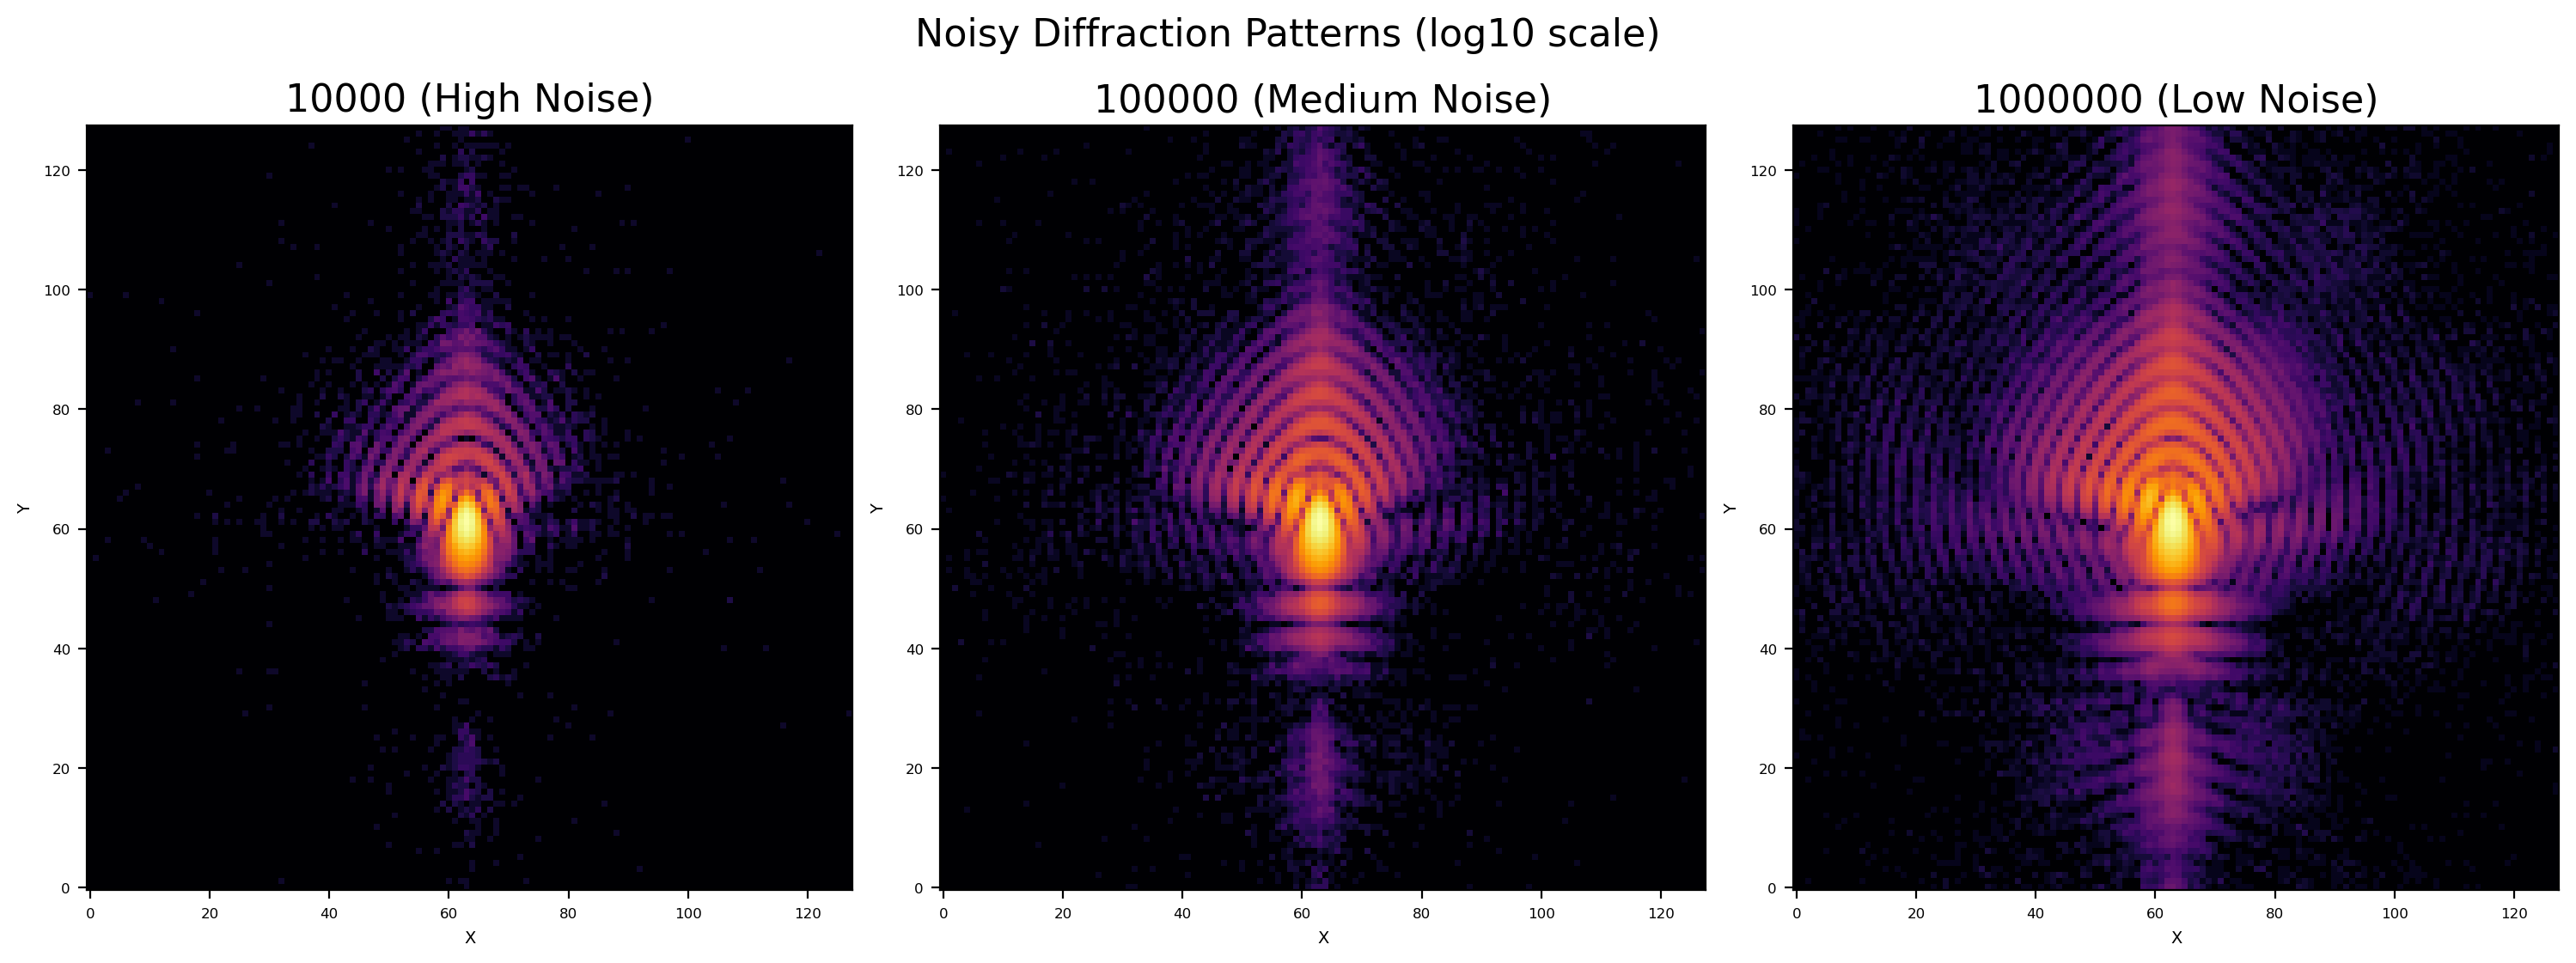

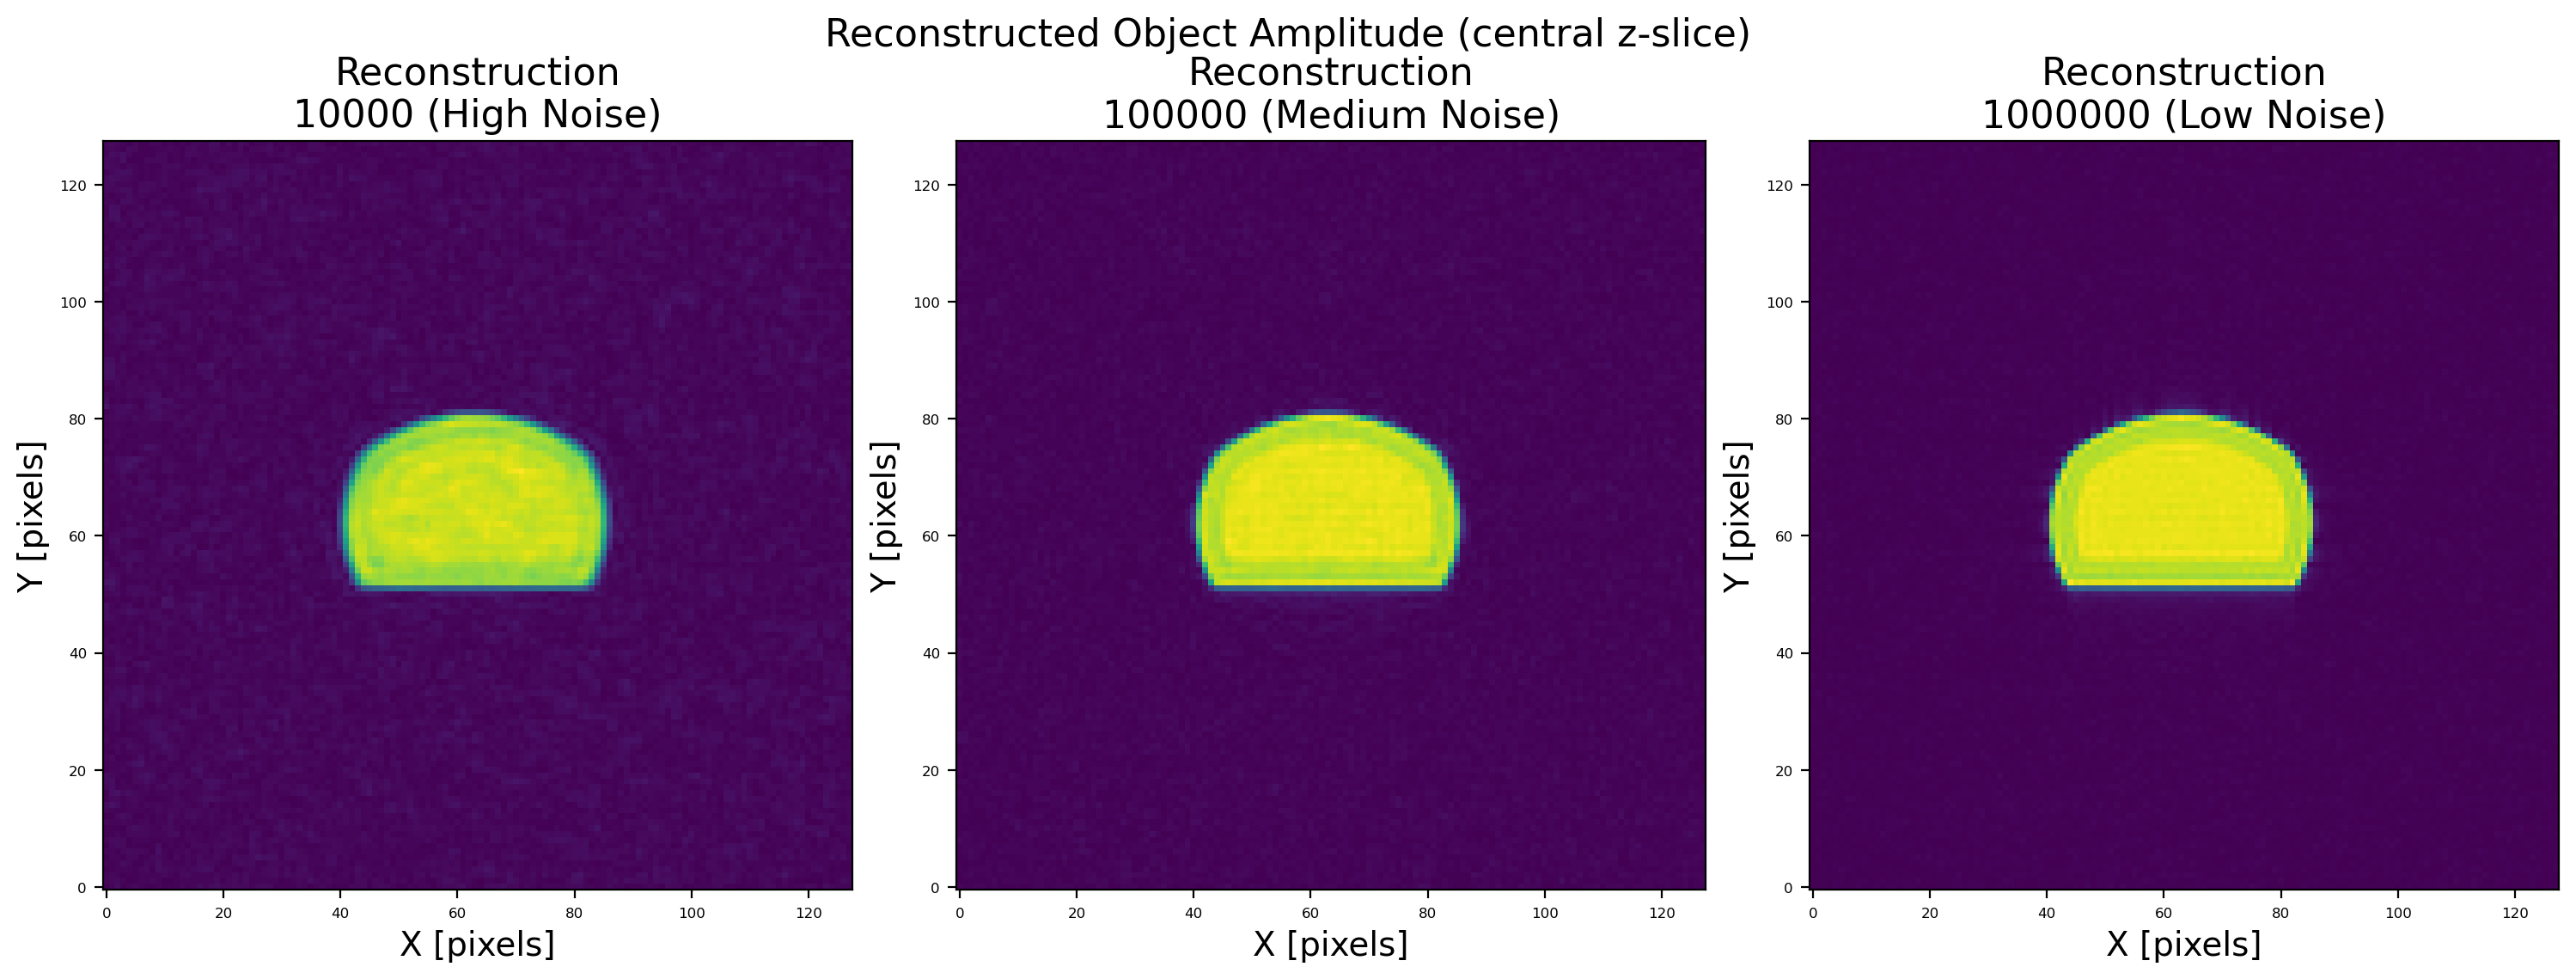

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Define your Poisson factors and labels
poisson_factors = [10000, 100000, 1000000]
labels = ["10000 (High Noise)", "100000 (Medium Noise)", "1000000 (Low Noise)"]

# Store results in a list for easy looping
results = []
for factor in poisson_factors:
    data, data_noise, obj_noise = create_poisson_obj(obj, factor)
    results.append({
        'data_noise': data_noise,
        'obj_noise': obj_noise,
    })

# Calculate central slice indices once
shape = results[0]['data_noise'].shape
z_c, y_c, x_c = [d // 2 for d in shape]

# Plot noisy diffraction patterns (central z-slice, y-slice, x-slice for each)
fig, axs = plt.subplots(1, 3, figsize=(15, 5.5))
for i, res in enumerate(results):
    dn = res['data_noise']
    axs[i].imshow(np.rot90(np.log10(1 + dn[z_c, :, :]), k=-1), cmap='inferno', origin='lower')
    axs[i].set_title(f"{labels[i]}", fontsize = 16)
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    # axs[i, 1].imshow(np.log10(1 + dn[:, y_c, :]), cmap='inferno', origin='lower')
    # axs[i, 1].set_title(f"{labels[i]}\n(y-slice)")
    # axs[i, 1].set_xlabel('X')
    # axs[i, 1].set_ylabel('Z')
    # axs[i, 2].imshow(np.log10(1 + dn[:, :, x_c]), cmap='inferno', origin='lower')
    # axs[i, 2].set_title(f"{labels[i]}\n(x-slice)")
    # axs[i, 2].set_xlabel('Y')
    # axs[i, 2].set_ylabel('Z')
plt.tight_layout()
plt.suptitle("Noisy Diffraction Patterns (log10 scale)", fontsize=16, y=1.02)
plt.show()

# shape = results[0]['data_noise'].shape
# z_c, y_c, x_c = [d // 2 for d in shape]

# Plot amplitude of reconstructed objects (central z-slice for each)
fig, axs = plt.subplots(1, 3, figsize=(15, 5.5))
for i, res in enumerate(results):
    obj_n = np.abs(res['obj_noise'])
    axs[i].imshow(np.rot90(obj_n[z_c, :, :], k=-1), cmap='viridis', origin='lower')
    axs[i].set_title(f"Reconstruction\n{labels[i]}", fontsize = 16)
    axs[i].set_xlabel('X [pixels]', fontsize = 14)
    axs[i].set_ylabel('Y [pixels]', fontsize = 14)
plt.tight_layout()
plt.suptitle("Reconstructed Object Amplitude (central z-slice)", fontsize=16, y=1.02)
plt.show()


# For NanoMAD
### Creating 3x11 diffraction patterns with hkl 
### WITH NOISE

# Now going to prep the three files we need for NanoMAD
### cell.dat, FpFs.dat, HKLMAD.dat 

### cell.dat

In [24]:
# # Write a file that has the lattice parameters a, b, c, the angles, and the spacegroup (can just put P1 as spacegroup is ignored)
# # Variables you already have
# lattice_parameter_a, lattice_parameter_b, lattice_parameter_c = 3.536478759837648, 3.536478759837648, 3.536478759837648
# alpha, beta, gamma = 90, 90, 90
# spacegroup = "P1"

# # Variables for folder naming
# type = "sim_big_particle"     # DONT FORGET TO CHANGE THESES IF NECESSARY
# noise_level = "none"          # DONT OVERWRITE OTHER DATA

# # Base save path
# base_path = f"/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/data_files/"

# # Construct folder name and ensure it exists
# folder_name = f"{type}_noise_{noise_level}"
# output_dir = os.path.join(base_path, folder_name)
# os.makedirs(output_dir, exist_ok=True)

# # File name based on folder
# file_name = f"cell_{folder_name}.dat"
# output_path = os.path.join(output_dir, file_name)

# # Write file
# with open(output_path, "w") as f:
#     f.write(f"{lattice_parameter_a} {lattice_parameter_b} {lattice_parameter_c} "
#             f"{alpha} {beta} {gamma} {spacegroup}\n")

# print(f"Written: {output_path}")


### FpFs.dat

In [25]:
# import os
# import numpy as np

# # --- Inputs you already have / set earlier ---
# E0 = 8333  # example
# energies = [E0-50, E0-20, E0-10, E0-5, E0-2, E0-1, E0, E0+1, E0+2, E0+5, E0+10]

# # Folder naming
# type = "sim_big_particle"
# noise_level = "none"
# base_path = f"/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/data_files/"

# # Ensure output dir exists
# folder_name = f"{type}_noise_{noise_level}"
# output_dir = os.path.join(base_path, folder_name)
# os.makedirs(output_dir, exist_ok=True)

# # --- Formatting helpers ---
# def format_energy(e):
#     if np.isclose(e, round(e), atol=1e-8):
#         return f"{int(round(e))}"
#     s = f"{e:.4f}"
#     return s.rstrip("0").rstrip(".")

# def format_line(vals, ndp=2):
#     return " ".join(f"{v:.{ndp}f}" for v in vals)

# # --- Writer ---
# def write_fpfs_for_element(element: str, energies_eV, ndp=2):
#     f1_interp = scat_factors[element]["f1_interp"]
#     f2_interp = scat_factors[element]["f2_interp"]

#     energies_eV = np.asarray(energies_eV, dtype=float)
#     f1_vals = f1_interp(energies_eV).ravel()
#     f2_vals = f2_interp(energies_eV).ravel()

#     n_energies = len(energies_eV)
#     file_name = f"FpFs_{element}_{folder_name}.dat"
#     output_path = os.path.join(output_dir, file_name)

#     # Build file content as list of strings
#     lines = []
#     lines.append(f"{element} {n_energies}")
#     lines.append(" ".join(format_energy(e) for e in energies_eV))
#     lines.append(format_line(f1_vals, ndp=ndp))
#     lines.append(format_line(f2_vals, ndp=ndp))

#     # Write to file
#     with open(output_path, "w") as f:
#         f.write("\n".join(lines) + "\n")

#     # Print a preview
#     print(f"\nWrote: {output_path}")
#     print("----- File preview -----")
#     for line in lines:
#         print(line)
#     print("------------------------")

# # --- Write both Ni and Fe ---
# for el in ("Ni", "Fe"):
#     write_fpfs_for_element(el, energies, ndp=2)



### HKLMAD.dat

In [26]:
# import os
# import re
# import numpy as np

# # -----------------------
# # CONFIG
# # -----------------------
# # Where the .npy volumes live (one per energy)
# packed_dir = "/data/id01/inhouse/tsarrazin/BCDI_reconstructions/BigParticle_simulations/Ni3Fe/11energies/noise_none/"

# # Output folder (same style you used for NanoMAD files)
# type = "sim_big_particle"
# noise_level = "none"
# base_path = f"/data/id01/inhouse/tsarrazin/Concentration/NanoMAD/Paper/data_files/"
# folder_name = f"{type}_noise_{noise_level}"
# output_dir = os.path.join(base_path, folder_name)
# os.makedirs(output_dir, exist_ok=True)

# # Output file
# hklmad_path = os.path.join(output_dir, f"HKLMAD_{folder_name}.dat")

# # Numeric tolerance to consider HKL arrays "the same"
# HKL_TOL = 1e-8  # tighten/relax as needed

# # How many preview lines to print
# N_PREVIEW = 3

# # -----------------------
# # HELPERS
# # -----------------------
# _energy_re = re.compile(r"packed_diff_hkl_(\d+(?:\.\d+)?)eV\.npy$")

# def extract_energy(fname: str) -> float:
#     m = _energy_re.search(os.path.basename(fname))
#     if not m:
#         raise ValueError(f"Cannot parse energy from filename: {fname}")
#     return float(m.group(1))

# def list_packed_files_sorted_by_energy(directory: str) -> list[tuple[float, str]]:
#     files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".npy")]
#     pairs = [(extract_energy(f), f) for f in files]
#     pairs.sort(key=lambda x: x[0])
#     return pairs  # list of (energy_eV, filepath)

# def check_hkl_consistency(h_ref, k_ref, l_ref, h, k, l, tol=HKL_TOL) -> dict:
#     """Return max abs diffs and a boolean 'ok' flag."""
#     dh = np.nanmax(np.abs(h - h_ref))
#     dk = np.nanmax(np.abs(k - k_ref))
#     dl = np.nanmax(np.abs(l - l_ref))
#     ok = (dh <= tol) and (dk <= tol) and (dl <= tol)
#     return {"max_dH": float(dh), "max_dK": float(dk), "max_dL": float(dl), "ok": ok}

# # -----------------------
# # LOAD & CHECK
# # -----------------------
# pairs = list_packed_files_sorted_by_energy(packed_dir)
# if not pairs:
#     raise FileNotFoundError(f"No .npy files found in {packed_dir}")

# energies_eV = [e for e, _ in pairs]
# print(f"Found {len(pairs)} volumes:", energies_eV)

# # Load first as reference
# e0, f0 = pairs[0]
# ref = np.load(f0)  # shape expected: (4, nqx, nqy, nqz)
# assert ref.ndim == 4 and ref.shape[0] == 4, f"Unexpected shape for {f0}: {ref.shape}"

# I_ref = ref[0]  # intensity (reference energy)
# H_ref = ref[1]
# K_ref = ref[2]
# L_ref = ref[3]

# shape = I_ref.shape
# nb_points = int(np.prod(shape))

# # Collect intensities per energy; check HKL consistency
# intensity_stack = [I_ref]  # list of 3D arrays (one per energy)
# ok_all = True
# max_diffs = []

# for e, fp in pairs[1:]:
#     arr = np.load(fp)
#     assert arr.shape == ref.shape, f"Shape mismatch: {fp} has {arr.shape}, ref {ref.shape}"
#     I = arr[0]
#     H = arr[1]
#     K = arr[2]
#     L = arr[3]
#     # Check HKL consistency
#     stats = check_hkl_consistency(H_ref, K_ref, L_ref, H, K, L, tol=HKL_TOL)
#     max_diffs.append((e, stats))
#     if not stats["ok"]:
#         ok_all = False
#     intensity_stack.append(I)

# print(f"Grid shape: {shape} -> nb_points = {nb_points}")
# if max_diffs:
#     print("HKL max abs diffs vs reference:")
#     for e, s in max_diffs:
#         print(f"  E={e:g} eV -> dH={s['max_dH']:.3e}, dK={s['max_dK']:.3e}, dL={s['max_dL']:.3e}, OK={s['ok']}")
# else:
#     print("Only one energy found; HKL consistency trivially OK.")

# if not ok_all:
#     print("\n⚠️ HKL arrays are NOT consistent across energies (above tolerance).")
#     print("Investigate HKL generation (grid spacing/rounding/units). Aborting HKLMAD write.")
# else:
#     print("\n✅ HKL arrays are consistent within tolerance. Proceeding to write HKLMAD.dat...")

#     # -----------------------
#     # WRITE HKLMAD.DAT
#     # -----------------------
#     # Flatten H, K, L and intensities in a *consistent* order
#     H_flat = H_ref.ravel(order="C")
#     K_flat = K_ref.ravel(order="C")
#     L_flat = L_ref.ravel(order="C")

#     # Stack intensities [nb_points, n_energies]
#     I_matrix = np.column_stack([I.ravel(order="C") for I in intensity_stack])  # shape (nb_points, nE)

#     # Write progressively to avoid huge in-memory strings
#     with open(hklmad_path, "w") as f:
#         # Line 1: number of points
#         f.write(f"{nb_points}\n")
#         # Next lines: H K L I(E1) I(E2) ... I(En)
#         # Formatting: HKL with 5 decimals, intensities with 6 significant digits (scientific if needed)
#         for i in range(nb_points):
#             h, k, l = H_flat[i], K_flat[i], L_flat[i]
#             intensities = I_matrix[i, :]
#             hkl_str = f"{h:.5f} {k:.5f} {l:.5f}"
#             inten_str = " ".join(f"{val:.6g}" for val in intensities)
#             f.write(f"{hkl_str} {inten_str}\n")

#     # -----------------------
#     # PREVIEW
#     # -----------------------
#     print(f"\nWrote: {hklmad_path}")
#     print("----- HKLMAD preview -----")
#     print(f"{nb_points}")
#     for i in range(min(N_PREVIEW, nb_points)):
#         h, k, l = H_flat[i], K_flat[i], L_flat[i]
#         intensities = I_matrix[i, :]
#         hkl_str = f"{h:.5f} {k:.5f} {l:.5f}"
#         # Show only first/last 3 intensities if there are many
#         nE = intensities.size
#         if nE <= 8:
#             inten_preview = " ".join(f"{val:.6g}" for val in intensities)
#         else:
#             first3 = " ".join(f"{val:.6g}" for val in intensities[:3])
#             last3  = " ".join(f"{val:.6g}" for val in intensities[-3:])
#             inten_preview = f"{first3} ... {last3}"
#         print(f"{hkl_str} {inten_preview}")
#     print("... (truncated) ...")
#     print("--------------------------")


In [27]:
# /data/id01/inhouse/tsarrazin/BCDI_reconstructions/BigParticle_simulations/Ni3Fe/11energies/noise_none

#### CdiUtils's routine
Here we are going to unwrap the phase, calculate the dipslacement, strain and d-spacing fields. For this we need the $\vec{g}_{[hkl]}$ vector.  This the reciprocal space position associated with the center of mass of our diffracted intensity. 

In [28]:
# Recycle above code:
total_intensity = np.sum(full_diff_pattern)
q_com = []
for q in (qx, qy, qz):
    q_com.append(np.sum((full_diff_pattern * q)) / total_intensity)

d_spacing = 1 / np.linalg.norm(q_com)
print(
    f"d-spacing and associated lattice parameter are: {d_spacing} and "
    f"{d_spacing * np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)} A."
)

d-spacing and associated lattice parameter are: 2.0424786196149434 and 3.5376767425462283 A.


In [29]:
struct_properties = cdiutils.process.PostProcessor.get_structural_properties(
    obj,
    isosurface=0.2,
    g_vector=tuple(q * (2*np.pi) for q in q_com),
    hkl=[1, 1, 1],
    voxel_size=voxel_size,
)
for k in struct_properties:
    print(k)

amplitude
support
surface
phase
displacement
displacement_gradient
het_strain
het_strain_with_ramp
het_strain_from_dspacing
numpy_het_strain
dspacing
lattice_parameter
hkl
g_vector
voxel_size


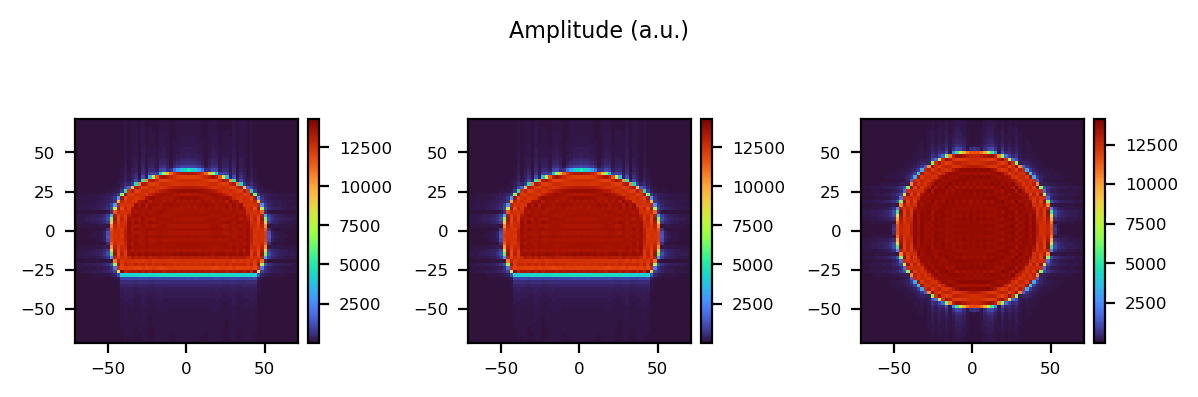

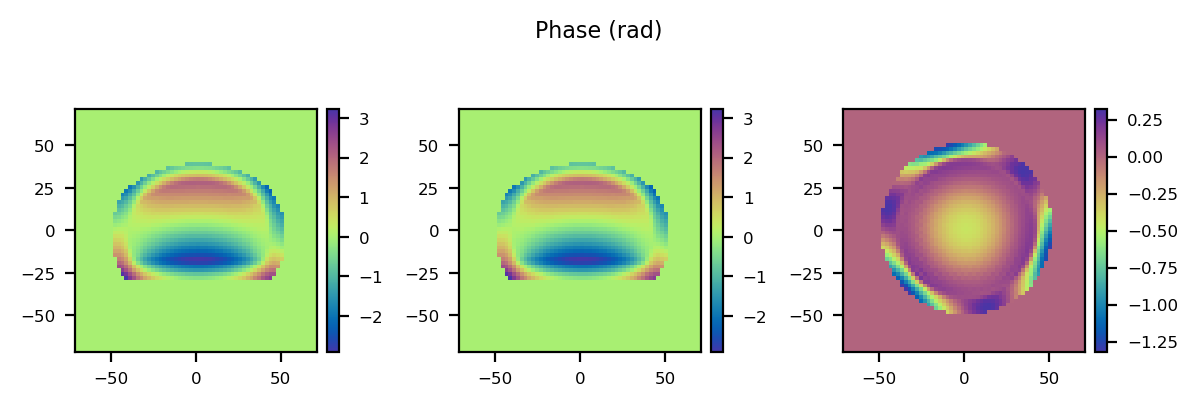

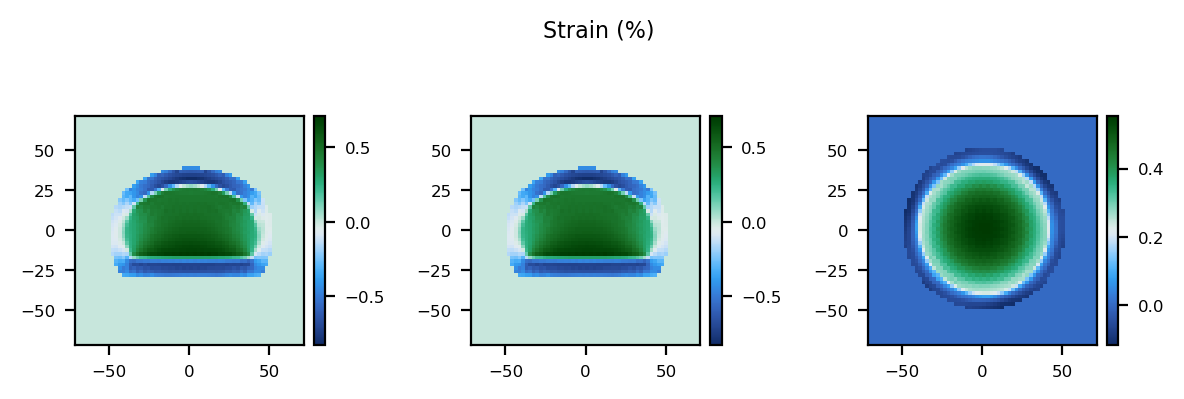

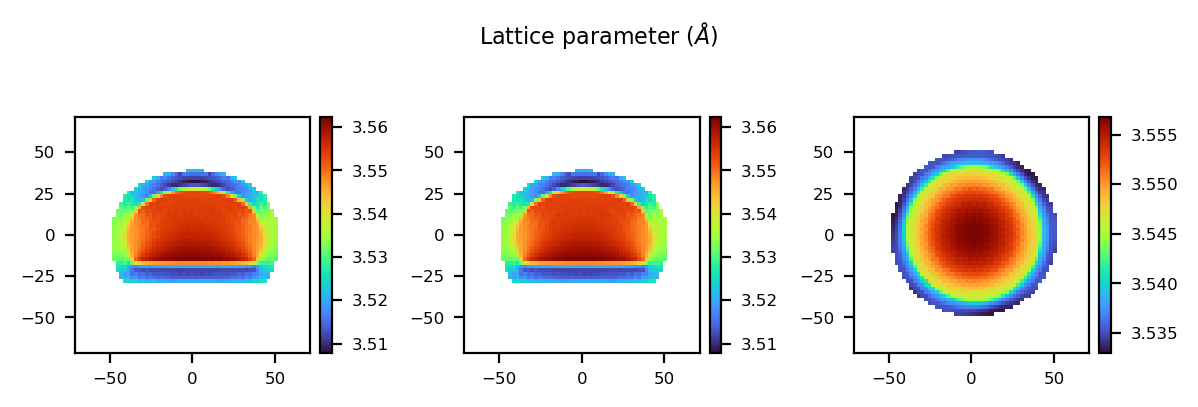

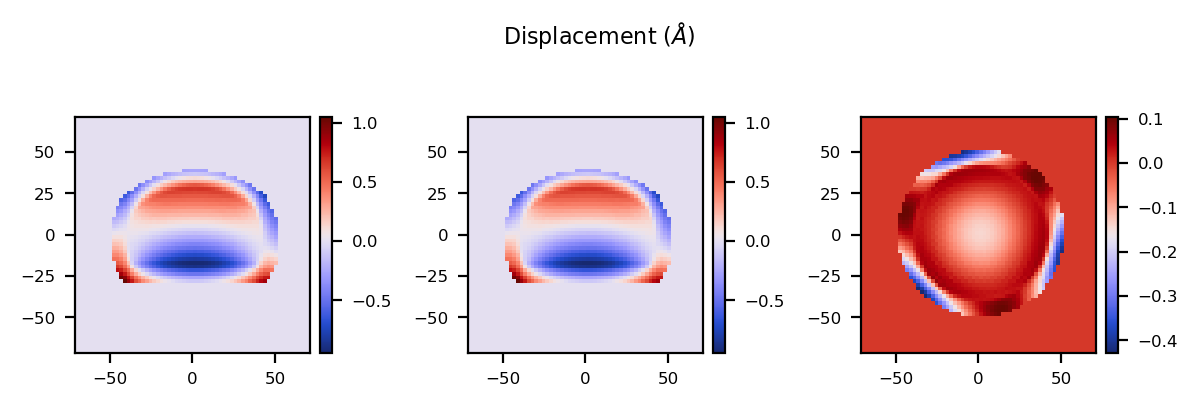

3.5371289723251222


In [30]:
for k in ("amplitude", "phase", "het_strain_from_dspacing", "lattice_parameter", "displacement"):
    plot_params.update(cdiutils.plot.get_plot_configs(k))
    plot_params["vmin"], plot_params["vmax"] = None, None
    cdiutils.plot.plot_volume_slices(struct_properties[k], **plot_params)

print(np.nanmean(struct_properties["lattice_parameter"]))

In [31]:
energies = {"E1": 8333, "E2": 3283}
# energies = {"E1": 7112, "E2": 8333}
colours = {"E1": "crimson", "E2": "navy"}
scattered_amps = {k: None for k in energies}
diff_patterns = {k: None for k in energies}
struct_properties = {k: None for k in energies}

In [32]:
plot_params = {
    "voxel_size": (dq[0], dq[1], dq[2]), "convention": "xu",
    "data_centre":(np.mean(qx), np.mean(qy), np.mean(qz)),
}

for k in scattered_amps:
    print(f"[INFO] working on energy = {energies[k]}")
    scattered_amps[k] = energy_dependent_scattered_amp(
        qx, qy, qz,
        (Fe_positions, scat_factors["Fe"]["full"]),
        (Ni_positions, scat_factors["Ni"]["full"]),
        energy=energies[k]
    )
    diff_patterns[k] = np.abs(scattered_amps[k])**2

print("Done.")


[INFO] working on energy = 8333
[INFO] working on energy = 3283
Done.


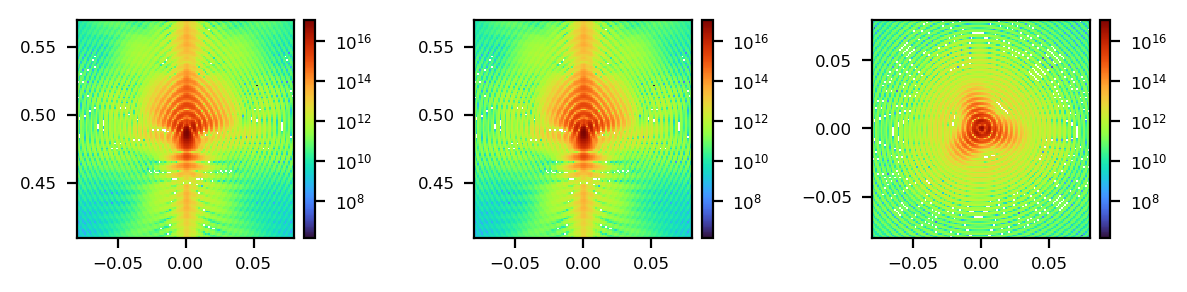

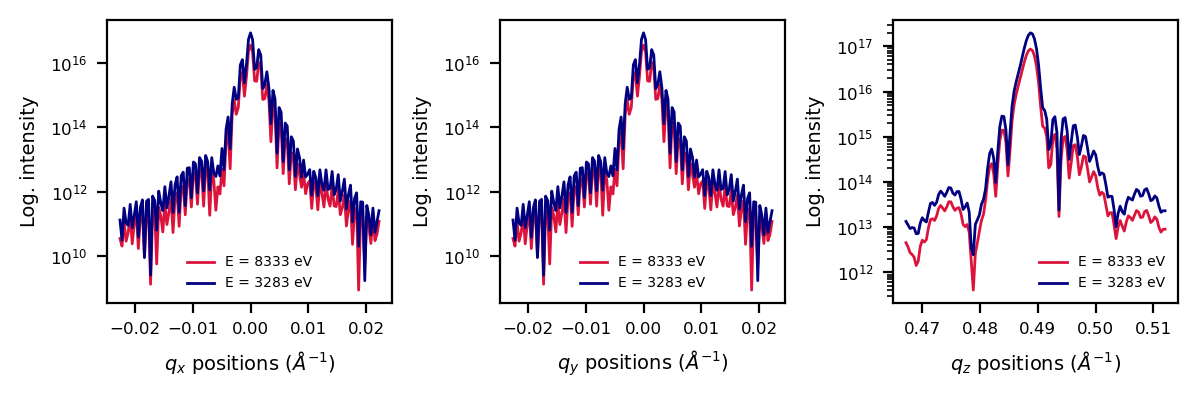

In [33]:
delta_diff_pattern = diff_patterns["E2"] - diff_patterns["E1"]

# cdiutils.plot.plot_volume_slices(
#     delta_diff_pattern, norm=LogNorm(), **plot_params
# )

cdiutils.plot.plot_volume_slices(
    diff_patterns["E2"] - diff_patterns["E1"], norm=LogNorm(), **plot_params
)




fig, axes = plt.subplots(1, 3, figsize=(6, 2), layout="tight")
for i, (ax, q) in enumerate(zip(axes.flat, (qx, qy, qz))):
    slices = [slice(shape[k] // 2, shape[k] // 2+1, 1) for k in range(3)]
    slices[i] = slice(None)
    slices = tuple(slices)

    ax.plot(q[slices].ravel(), diff_patterns["E1"][slices].ravel(), c="crimson", label=f"E = {energies['E1']} eV")
    ax.plot(q[slices].ravel(), diff_patterns["E2"][slices].ravel(), c="navy", label=f"E = {energies['E2']} eV")
    ax.set_yscale("log")
    ax.set_ylabel("Log. intensity")
    ax.legend(frameon=False, fontsize=5)

axes[0].set_xlabel(r"$q_x$ positions ($\AA ^{-1}$)")
axes[1].set_xlabel(r"$q_y$ positions ($\AA ^{-1}$)")
axes[2].set_xlabel(r"$q_z$ positions ($\AA ^{-1}$)");



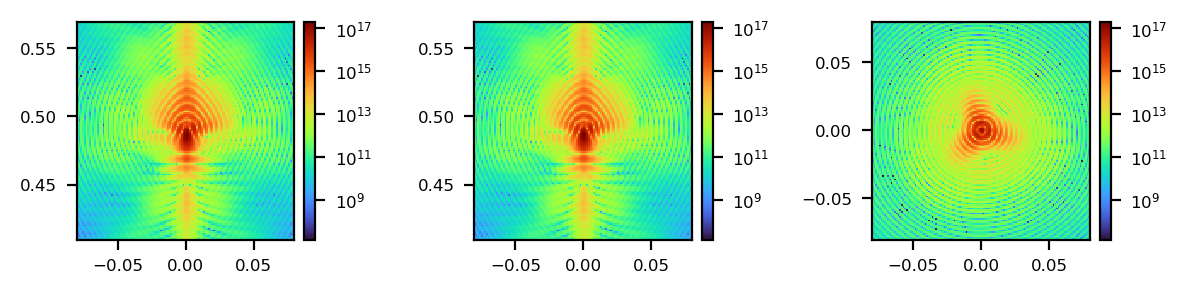

(<Figure size 1200x400 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [34]:
cdiutils.plot.plot_volume_slices(
    diff_patterns["E2"], norm=LogNorm(), **plot_params
)


Object shape: (128, 128, 128)
Object dtype: complex128
Amplitude range: [7.330e-06, 1.441e+04]

Support shape: (128, 128, 128)
Support voxels (inside): 35583
Support fraction: 1.7% of volume

✓ Support saved to: /data/id01/inhouse/tsarrazin/Concentration/supports/clean_support_128_isosurf75.npy


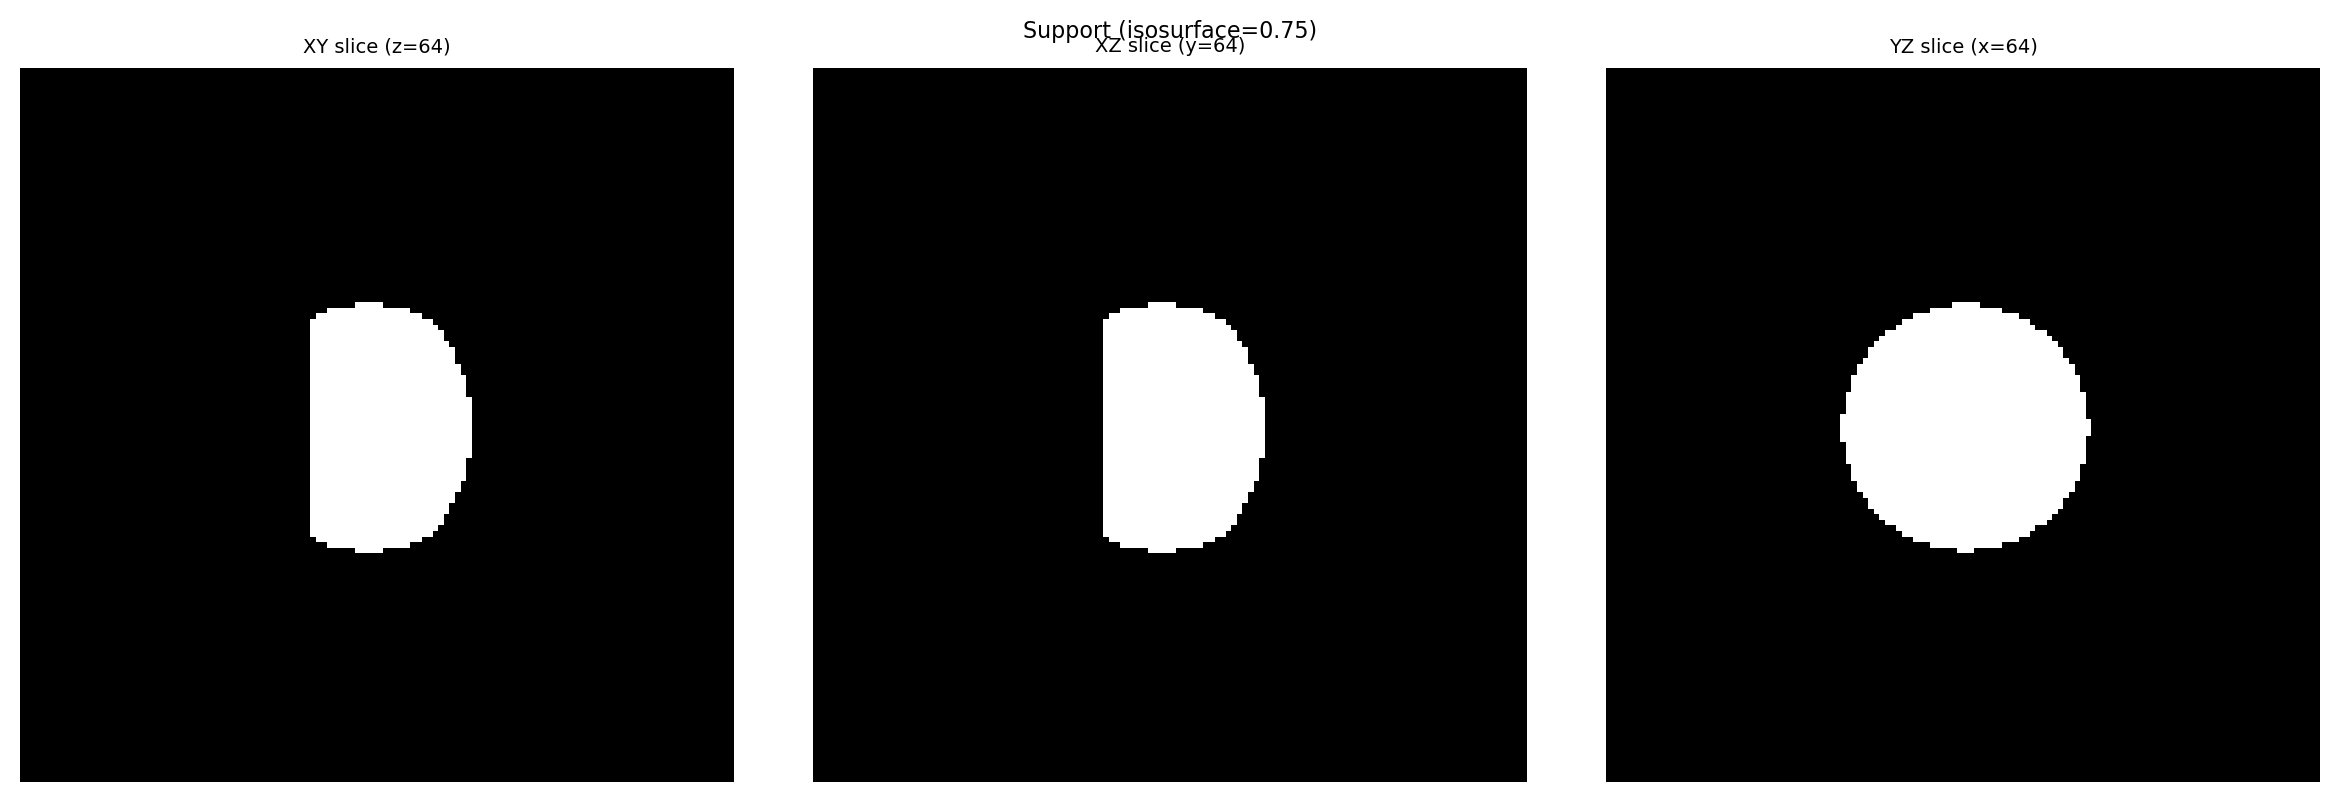

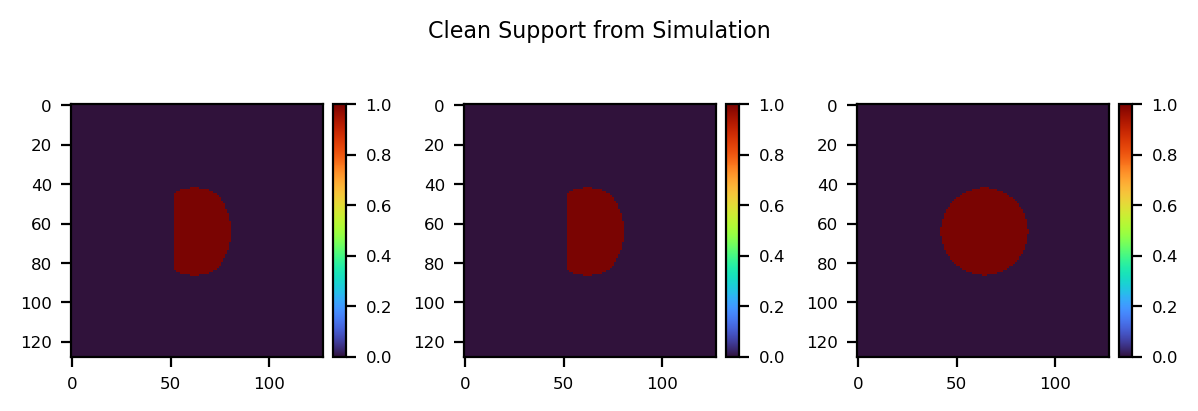

In [35]:
# =============================================================================
# SUPPORT EXTRACTION CELL
# Add this at the end of BigParticle_V2_2_Paper_Haag_NanoMAD notebook
# =============================================================================

from scipy.fft import fftn, ifftn, fftshift, ifftshift
import numpy as np
import os

# -----------------------------------------------------------------------------
# 1. Reconstruct real-space object from scattered amplitude
# -----------------------------------------------------------------------------
# full_scattered_amp should already exist from the simulation (computed ~line 763-771)
# This inverse FFT gives us the real-space electron density

obj = ifftshift(ifftn(fftshift(full_scattered_amp)))

print(f"Object shape: {obj.shape}")
print(f"Object dtype: {obj.dtype}")
print(f"Amplitude range: [{np.abs(obj).min():.3e}, {np.abs(obj).max():.3e}]")

# -----------------------------------------------------------------------------
# 2. Create support via isosurface thresholding
# -----------------------------------------------------------------------------
# isosurface=0.75 means: support includes voxels where |obj| > 0.75 * max(|obj|)
# Adjust this value if support is too tight (raise) or too loose (lower)

isosurface_threshold = 0.75  # <-- TUNE THIS IF NEEDED

support = cdiutils.utils.make_support(np.abs(obj), isosurface=isosurface_threshold)

# Convert to clean binary (0 or 1)
support_binary = (support > 0).astype(np.float64)

print(f"\nSupport shape: {support_binary.shape}")
print(f"Support voxels (inside): {support_binary.sum():.0f}")
print(f"Support fraction: {support_binary.mean()*100:.1f}% of volume")

# -----------------------------------------------------------------------------
# 3. Save to file
# -----------------------------------------------------------------------------
save_dir = "/data/id01/inhouse/tsarrazin/Concentration/supports"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"clean_support_128_isosurf{int(isosurface_threshold*100):02d}.npy")
np.save(save_path, support_binary)
print(f"\n✓ Support saved to: {save_path}")

# -----------------------------------------------------------------------------
# 4. Visualize for sanity check
# -----------------------------------------------------------------------------
# Central slices through the support
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

nz, ny, nx = support_binary.shape
axes[0].imshow(support_binary[nz//2, :, :], cmap='gray')
axes[0].set_title(f'XY slice (z={nz//2})')

axes[1].imshow(support_binary[:, ny//2, :], cmap='gray')
axes[1].set_title(f'XZ slice (y={ny//2})')

axes[2].imshow(support_binary[:, :, nx//2], cmap='gray')
axes[2].set_title(f'YZ slice (x={nx//2})')

for ax in axes:
    ax.axis('off')
    
plt.suptitle(f'Support (isosurface={isosurface_threshold})')
plt.tight_layout()
plt.show()

# If cdiutils has a 3D viewer, use that too:
try:
    cdiutils.plot.plot_volume_slices(support_binary, title="Clean Support from Simulation")
except:
    pass  # Skip if not available

# Trying the inverse FT of aplitude difference (bug in second step)
### Notice the core (core has Fe, shell is 100% Ni) is a much lower intensity
### Makes sense as the Nickel is the more resonant at 8333 vs 3283?

In [36]:
# voxel_size = tuple(1e-1 / np.ptp(q) for q in (qx, qy, qz))  # in nm

# print(f"Voxel size:{voxel_size}")

# plot_params = {
#     "support": support, "convention": "xu", "voxel_size": voxel_size,
#     "data_centre": (0, 0, 0)
# }

# total_intensity = np.sum(delta_diff_pattern) # What is fidd_patterns even for then?
# q_com = []
# for q in (qx, qy, qz):
#     q_com.append(np.sum(delta_diff_pattern * q) / total_intensity)

# d_spacing = 1 / np.linalg.norm(q_com)
# print(
#     f"[INFO] At E = {energies[k]}:\n"
#     f"d-spacing and associated lattice parameter are: {d_spacing} and "
#     f"{d_spacing * np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)} A."
# )

# print("energies: ", energies) 

# """Amplitude difference :D"""
# obj = ifftshift(ifftn(fftshift(scattered_amps['E1']-scattered_amps['E2'])))     ####################################################################################################################################

# # obj =  cdiutils.process.PostProcessor.apodize(obj)
# struct_properties[k] = cdiutils.process.PostProcessor.get_structural_properties(
#     obj,
#     isosurface=0.2,
#     g_vector = tuple(q * (2*np.pi) for q in q_com),
#     hkl=[1, 1, 1],
#     voxel_size=voxel_size,
# )
# for prop in ("amplitude", "het_strain_from_dspacing", "lattice_parameter"):
#     plot_params.update(cdiutils.plot.get_plot_configs(prop))
#     plot_params["vmin"], plot_params["vmax"] = None, None
#     cdiutils.plot.plot_volume_slices(struct_properties[k][prop], **plot_params)

# cropped_shape = struct_properties["E1"]["amplitude"].shape

# fig, axes = plt.subplots(1, 3, figsize=(6, 2), layout="tight")
# for i, ax in enumerate(axes.flat):
#     slices = [slice(cropped_shape[k] // 2, cropped_shape[k] // 2+1, 1) for k in range(3)]
#     slices[i] = slice(None)
#     slices = tuple(slices)

#     ax.plot(struct_properties["E1"]["amplitude"][slices].ravel(), c="crimson", label="E1")
#     ax.plot(struct_properties["E2"]["amplitude"][slices].ravel(), c="navy", label="E2")

#     ax.set_ylabel("Direct space amlitude")
#     ax.legend(frameon=False, fontsize=5)


# E1 and E2 start here!

voxel_size: (2.227703155803243, 2.227703155803243, 2.2277031558032423)
[INFO] At E = 8333:
d-spacing and associated lattice parameter are: 2.042473636934815 and 3.5376681122910876 A.


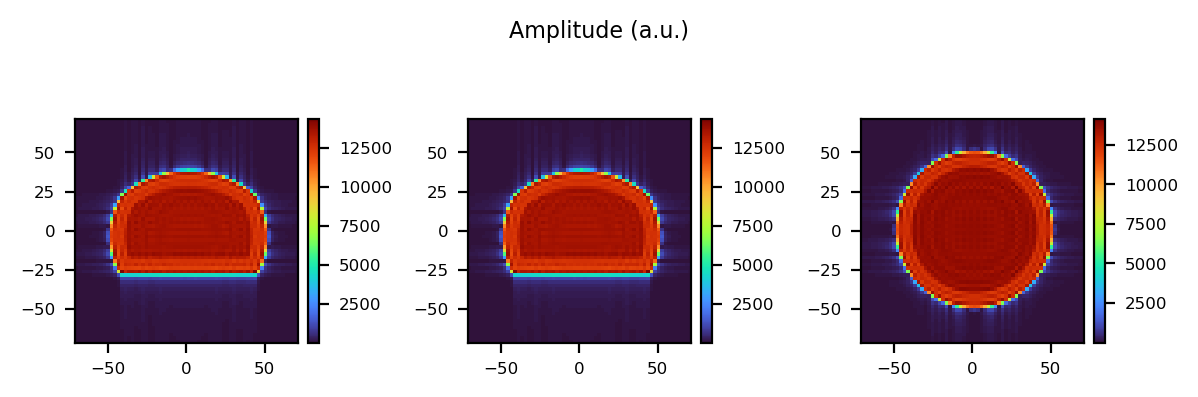

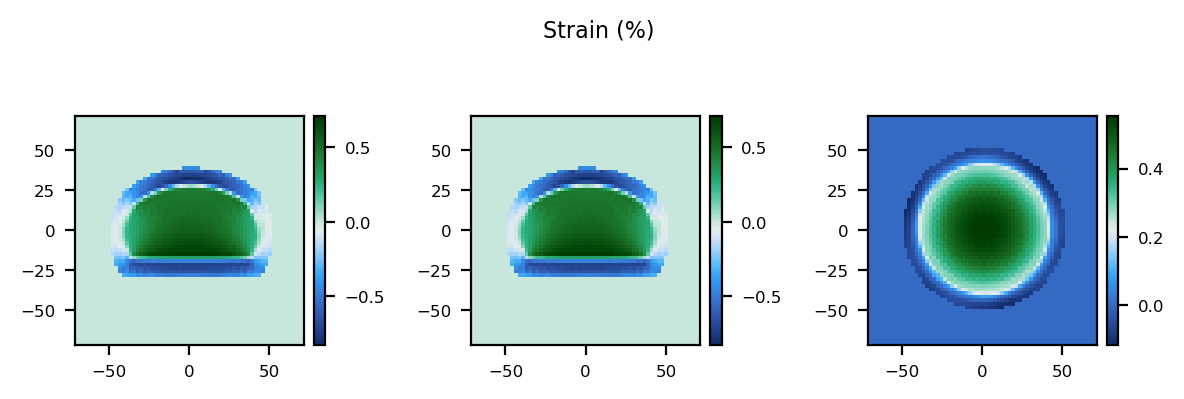

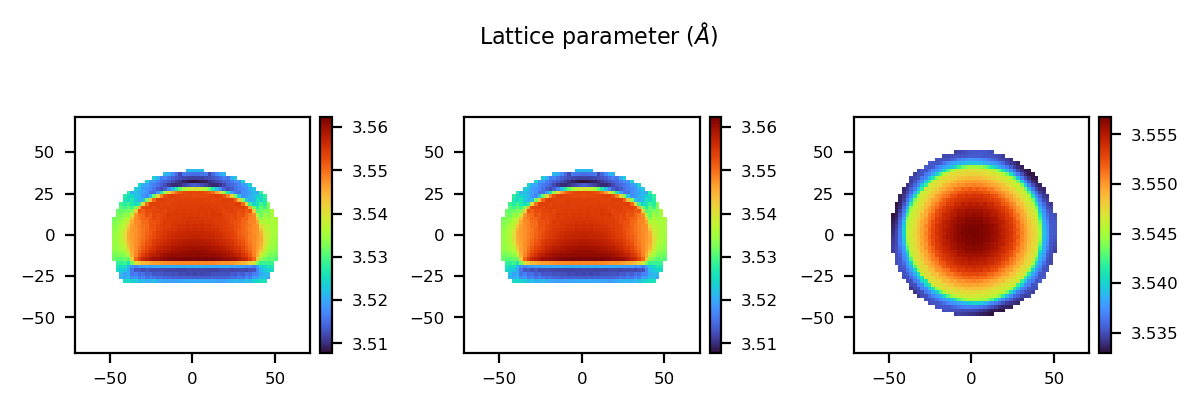

[INFO] At E = 3283:
d-spacing and associated lattice parameter are: 2.041490531047342 and 3.5359653229447647 A.


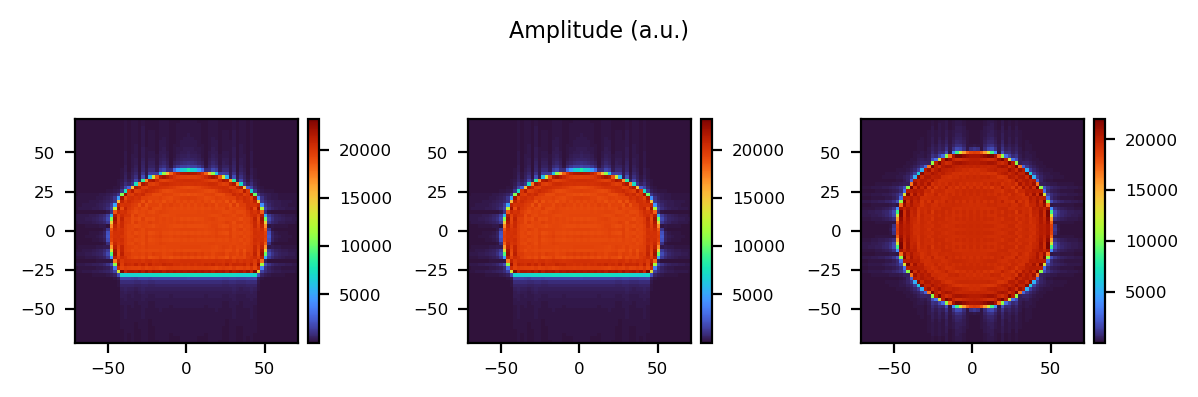

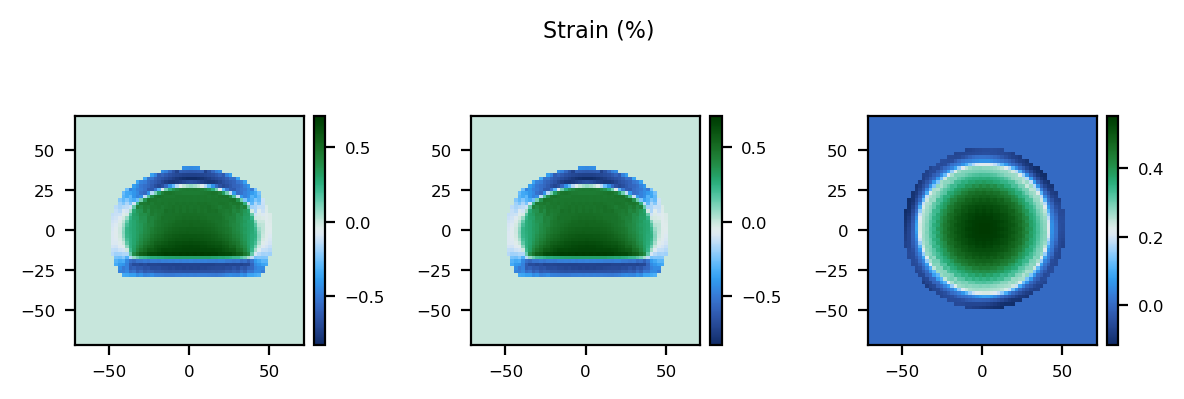

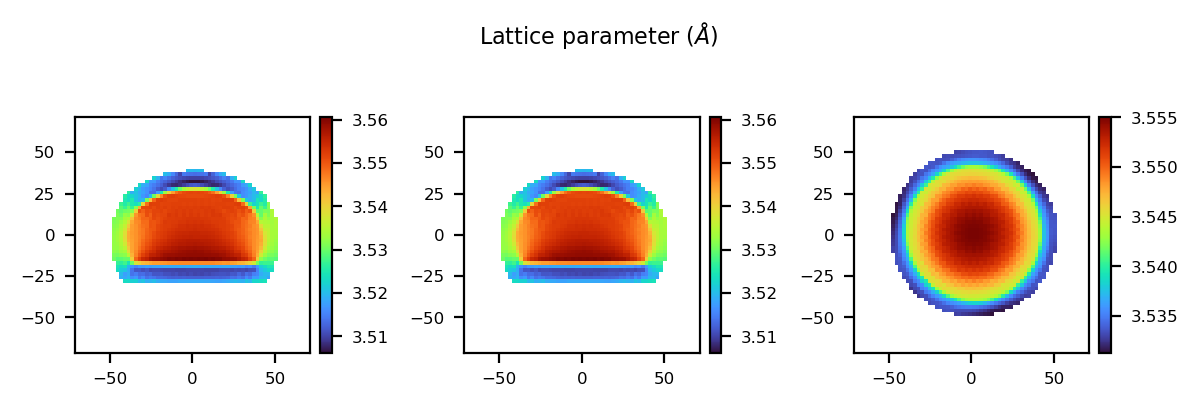

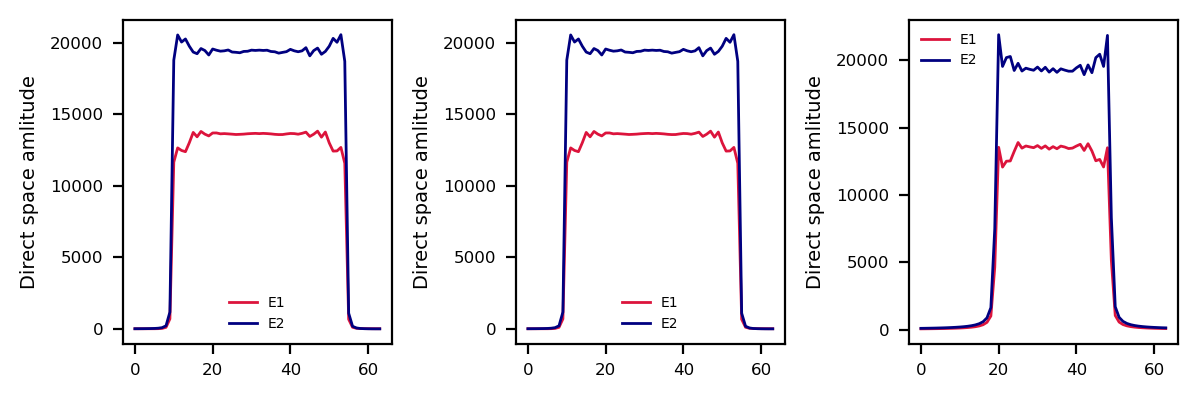

In [37]:
voxel_size = tuple(1e-1 / np.ptp(q) for q in (qx, qy, qz))  # in nm

print(f"voxel_size: {voxel_size}")

plot_params = {
    "support": support, "convention": "xu", "voxel_size": voxel_size,
    "data_centre": (0, 0, 0)
}

for k in energies:
    total_intensity = np.sum(diff_patterns[k])
    q_com = []
    for q in (qx, qy, qz):
        q_com.append(np.sum(diff_patterns[k] * q) / total_intensity)

    d_spacing = 1 / np.linalg.norm(q_com)
    print(
        f"[INFO] At E = {energies[k]}:\n"
        f"d-spacing and associated lattice parameter are: {d_spacing} and "
        f"{d_spacing * np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)} A."
    )
    obj = ifftshift(ifftn(fftshift(scattered_amps[k])))####################################################################################################################################
    # obj =  cdiutils.process.PostProcessor.apodize(obj)
    struct_properties[k] = cdiutils.process.PostProcessor.get_structural_properties(
        obj,
        isosurface=0.2,
        g_vector = tuple(q * (2*np.pi) for q in q_com),
        hkl=[1, 1, 1],
        voxel_size=voxel_size,
    )
    for prop in ("amplitude", "het_strain_from_dspacing", "lattice_parameter"):
        plot_params.update(cdiutils.plot.get_plot_configs(prop))
        plot_params["vmin"], plot_params["vmax"] = None, None
        cdiutils.plot.plot_volume_slices(struct_properties[k][prop], **plot_params)

cropped_shape = struct_properties["E1"]["amplitude"].shape

fig, axes = plt.subplots(1, 3, figsize=(6, 2), layout="tight")
for i, ax in enumerate(axes.flat):
    slices = [slice(cropped_shape[k] // 2, cropped_shape[k] // 2+1, 1) for k in range(3)]
    slices[i] = slice(None)
    slices = tuple(slices)

    ax.plot(struct_properties["E1"]["amplitude"][slices].ravel(), c="crimson", label="E1")
    ax.plot(struct_properties["E2"]["amplitude"][slices].ravel(), c="navy", label="E2")

    ax.set_ylabel("Direct space amlitude")
    ax.legend(frameon=False, fontsize=5)




Generating 3D diffraction volumes at 8 energies:
  [8313 8318 8323 8328 8333 8338 8343 8348]

Around Ni K-edge: 8333 eV
  Span: 35 eV

Computing 3D diffraction patterns...
 Done. Peak intensity: 1.13e+17
 Done. Peak intensity: 1.09e+17
 Done. Peak intensity: 1.04e+17
 Done. Peak intensity: 9.32e+16
 Done. Peak intensity: 8.73e+16
 Done. Peak intensity: 1.01e+17
 Done. Peak intensity: 1.11e+17
 Done. Peak intensity: 1.16e+17

✓ All 3D diffraction patterns computed

Cropping to 128×128×128 volumes...
  Original shape: (128, 128, 128)
  Cropped shape: (128, 128, 128)

✓ Created 3D intensity array
  Shape: (128, 128, 128, 8)
  Expected: (128, 128, 128, 8)
  Data type: float64
  Value range: [5.28e+03, 1.16e+17]


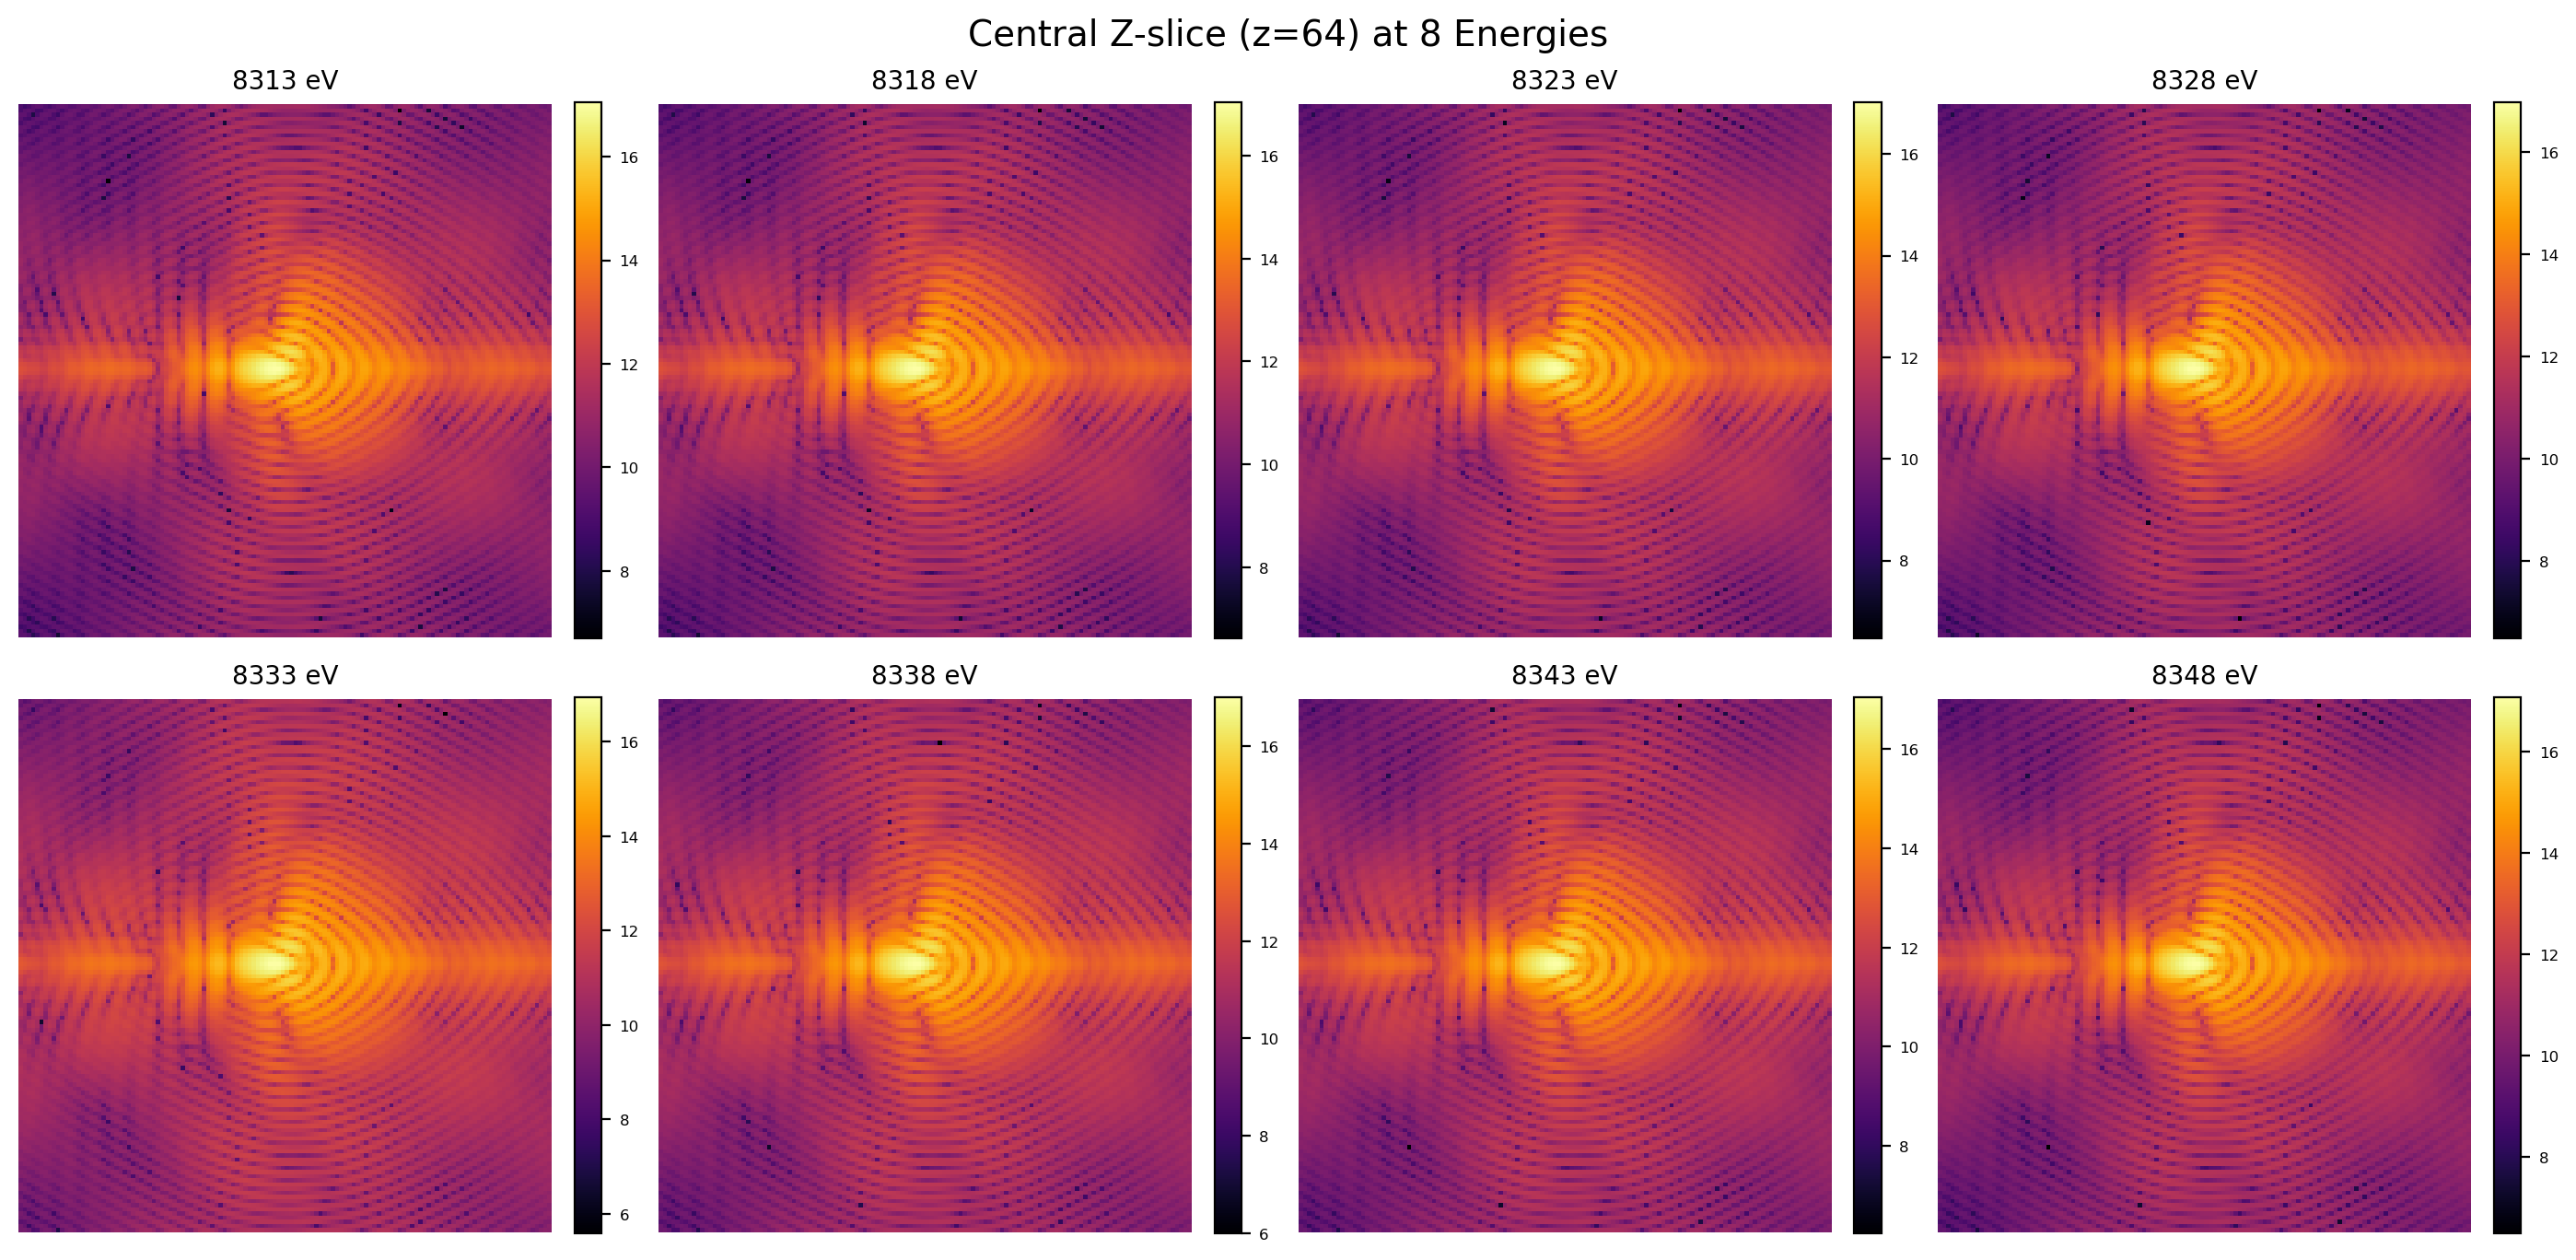


✓ 3D Dataset saved:
  /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean/test_intensity_3d.npy
  /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean/test_energies.npy
  /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean/test_3d_metadata.txt

Ready for inference with:
  python run_inference_3d.py -c checkpoint.pt --intensity /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean/test_intensity_3d.npy --energies /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean/test_energies.npy -o output/


In [38]:
# # Ran afternoon of 09/12/25
# # =============================================================================
# # GENERATE 3D TEST DATA FOR CNN (128×128×128×8)
# # =============================================================================
# # This version keeps the FULL 3D volume instead of just the central slice.
# # The inference script will handle slice-by-slice processing.
# # =============================================================================

# # %%
# # Cell 1: Define CNN energies and setup
# # -------------------------------------
# import numpy as np
# from pathlib import Path

# # The 8 energies the CNN expects (corrected for Ni K-edge at 8333 eV)
# CNN_ENERGIES = np.array([8313, 8318, 8323, 8328, 8333, 8338, 8343, 8348])  # eV

# OUTPUT_SIZE = 128  # 3D volume size

# print(f"Generating 3D diffraction volumes at {len(CNN_ENERGIES)} energies:")
# print(f"  {CNN_ENERGIES}")
# print(f"\nAround Ni K-edge: 8333 eV")
# print(f"  Span: {CNN_ENERGIES[-1] - CNN_ENERGIES[0]} eV")


# # %%
# # Cell 2: Generate multi-energy diffraction patterns
# # --------------------------------------------------
# scattered_amps = {}
# diff_patterns = {}

# print("\nComputing 3D diffraction patterns...")
# for i, energy in enumerate(CNN_ENERGIES):
#     print(f"  [{i+1}/{len(CNN_ENERGIES)}] E = {energy} eV...", end='')
    
#     scattered_amps[energy] = energy_dependent_scattered_amp(
#         qx, qy, qz,
#         (Fe_positions, scat_factors["Fe"]["full"]),
#         (Ni_positions, scat_factors["Ni"]["full"]),
#         energy=energy
#     )
    
#     diff_patterns[energy] = np.abs(scattered_amps[energy])**2
    
#     print(f" Done. Peak intensity: {diff_patterns[energy].max():.2e}")

# print("\n✓ All 3D diffraction patterns computed")


# # %%
# # Cell 3: Crop to 128×128×128 and stack into (D, H, W, E) format
# # --------------------------------------------------------------
# print(f"\nCropping to {OUTPUT_SIZE}×{OUTPUT_SIZE}×{OUTPUT_SIZE} volumes...")

# cropped_volumes = {}
# for energy in CNN_ENERGIES:
#     full_shape = diff_patterns[energy].shape
    
#     starts = [(s - OUTPUT_SIZE) // 2 for s in full_shape]
#     ends = [start + OUTPUT_SIZE for start in starts]
    
#     cropped_volumes[energy] = diff_patterns[energy][
#         starts[0]:ends[0],
#         starts[1]:ends[1],
#         starts[2]:ends[2]
#     ]

# print(f"  Original shape: {full_shape}")
# print(f"  Cropped shape: {cropped_volumes[CNN_ENERGIES[0]].shape}")

# # Stack into (D, H, W, E) format - THIS IS THE KEY CHANGE
# intensity_3d = np.stack([cropped_volumes[E] for E in CNN_ENERGIES], axis=-1)

# print(f"\n✓ Created 3D intensity array")
# print(f"  Shape: {intensity_3d.shape}")
# print(f"  Expected: ({OUTPUT_SIZE}, {OUTPUT_SIZE}, {OUTPUT_SIZE}, {len(CNN_ENERGIES)})")
# print(f"  Data type: {intensity_3d.dtype}")
# print(f"  Value range: [{intensity_3d.min():.2e}, {intensity_3d.max():.2e}]")


# # %%
# # Cell 4: Visualize central slices
# # --------------------------------
# import matplotlib.pyplot as plt

# z_center = OUTPUT_SIZE // 2

# fig, axes = plt.subplots(2, 4, figsize=(14, 7))
# fig.suptitle(f'Central Z-slice (z={z_center}) at 8 Energies', fontsize=14)

# for idx, (ax, energy) in enumerate(zip(axes.flat, CNN_ENERGIES)):
#     slice_2d = intensity_3d[z_center, :, :, idx]
#     im = ax.imshow(np.log10(slice_2d + 1), cmap='inferno', origin='lower')
#     ax.set_title(f'{energy} eV', fontsize=10)
#     ax.axis('off')
#     plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()


# # %%
# # Cell 5: Save 3D test dataset
# # ----------------------------
# save_dir = Path("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean")
# save_dir.mkdir(parents=True, exist_ok=True)

# # Save 3D intensity
# intensity_file = save_dir / "test_intensity_3d.npy"
# np.save(intensity_file, intensity_3d.astype(np.float32))

# # Save energies
# energies_file = save_dir / "test_energies.npy"
# np.save(energies_file, CNN_ENERGIES)

# # Save metadata
# metadata_file = save_dir / "test_3d_metadata.txt"
# with open(metadata_file, 'w') as f:
#     f.write("NanoMAD CNN 3D Test Dataset - Clean\n")
#     f.write("=" * 50 + "\n\n")
#     f.write(f"Intensity data shape: {intensity_3d.shape}\n")
#     f.write(f"Format: (D, H, W, E) = (depth, height, width, energies)\n")
#     f.write(f"Volume size: {OUTPUT_SIZE}×{OUTPUT_SIZE}×{OUTPUT_SIZE}\n")
#     f.write(f"N_energies: {len(CNN_ENERGIES)}\n\n")
#     f.write(f"Energies (eV): {CNN_ENERGIES.tolist()}\n")
#     f.write(f"Data type: {intensity_3d.dtype}\n")
#     f.write(f"Value range: [{intensity_3d.min():.2e}, {intensity_3d.max():.2e}]\n\n")
#     f.write(f"Particle info:\n")
#     f.write(f"  Fe atoms (core): {Fe_positions.shape[1]}\n")
#     f.write(f"  Ni atoms (shell): {Ni_positions.shape[1]}\n")
#     f.write(f"  Bragg peak: {hkl}\n")

# print("\n✓ 3D Dataset saved:")
# print(f"  {intensity_file}")
# print(f"  {energies_file}")
# print(f"  {metadata_file}")

# print(f"\nReady for inference with:")
# print(f"  python run_inference_3d.py -c checkpoint.pt --intensity {intensity_file} --energies {energies_file} -o output/")

Generating 3D noisy test dataset with Poisson factor = 1,000,000
  E = 8313 eV: max_clean = 1.13e+17, max_noisy = 1.00e+06, SNR ≈ 1389779063287752.5
  E = 8318 eV: max_clean = 1.09e+17, max_noisy = 1.00e+06, SNR ≈ 1338739018769213.2
  E = 8323 eV: max_clean = 1.04e+17, max_noisy = 1.00e+06, SNR ≈ 1277716452948539.2
  E = 8328 eV: max_clean = 9.32e+16, max_noisy = 1.00e+06, SNR ≈ 1140582736656863.2
  E = 8333 eV: max_clean = 8.73e+16, max_noisy = 1.00e+06, SNR ≈ 1069152576359389.2
  E = 8338 eV: max_clean = 1.01e+17, max_noisy = 1.00e+06, SNR ≈ 1235561172926169.8
  E = 8343 eV: max_clean = 1.11e+17, max_noisy = 1.00e+06, SNR ≈ 1364916886175116.8
  E = 8348 eV: max_clean = 1.16e+17, max_noisy = 9.99e+05, SNR ≈ 1427838739128639.2

✓ Poisson noise applied to all 3D patterns

Cropping noisy patterns to 128×128×128...

✓ Created 3D noisy intensity array
  Shape: (128, 128, 128, 8)
  Value range: [0.00e+00, 1.00e+06]


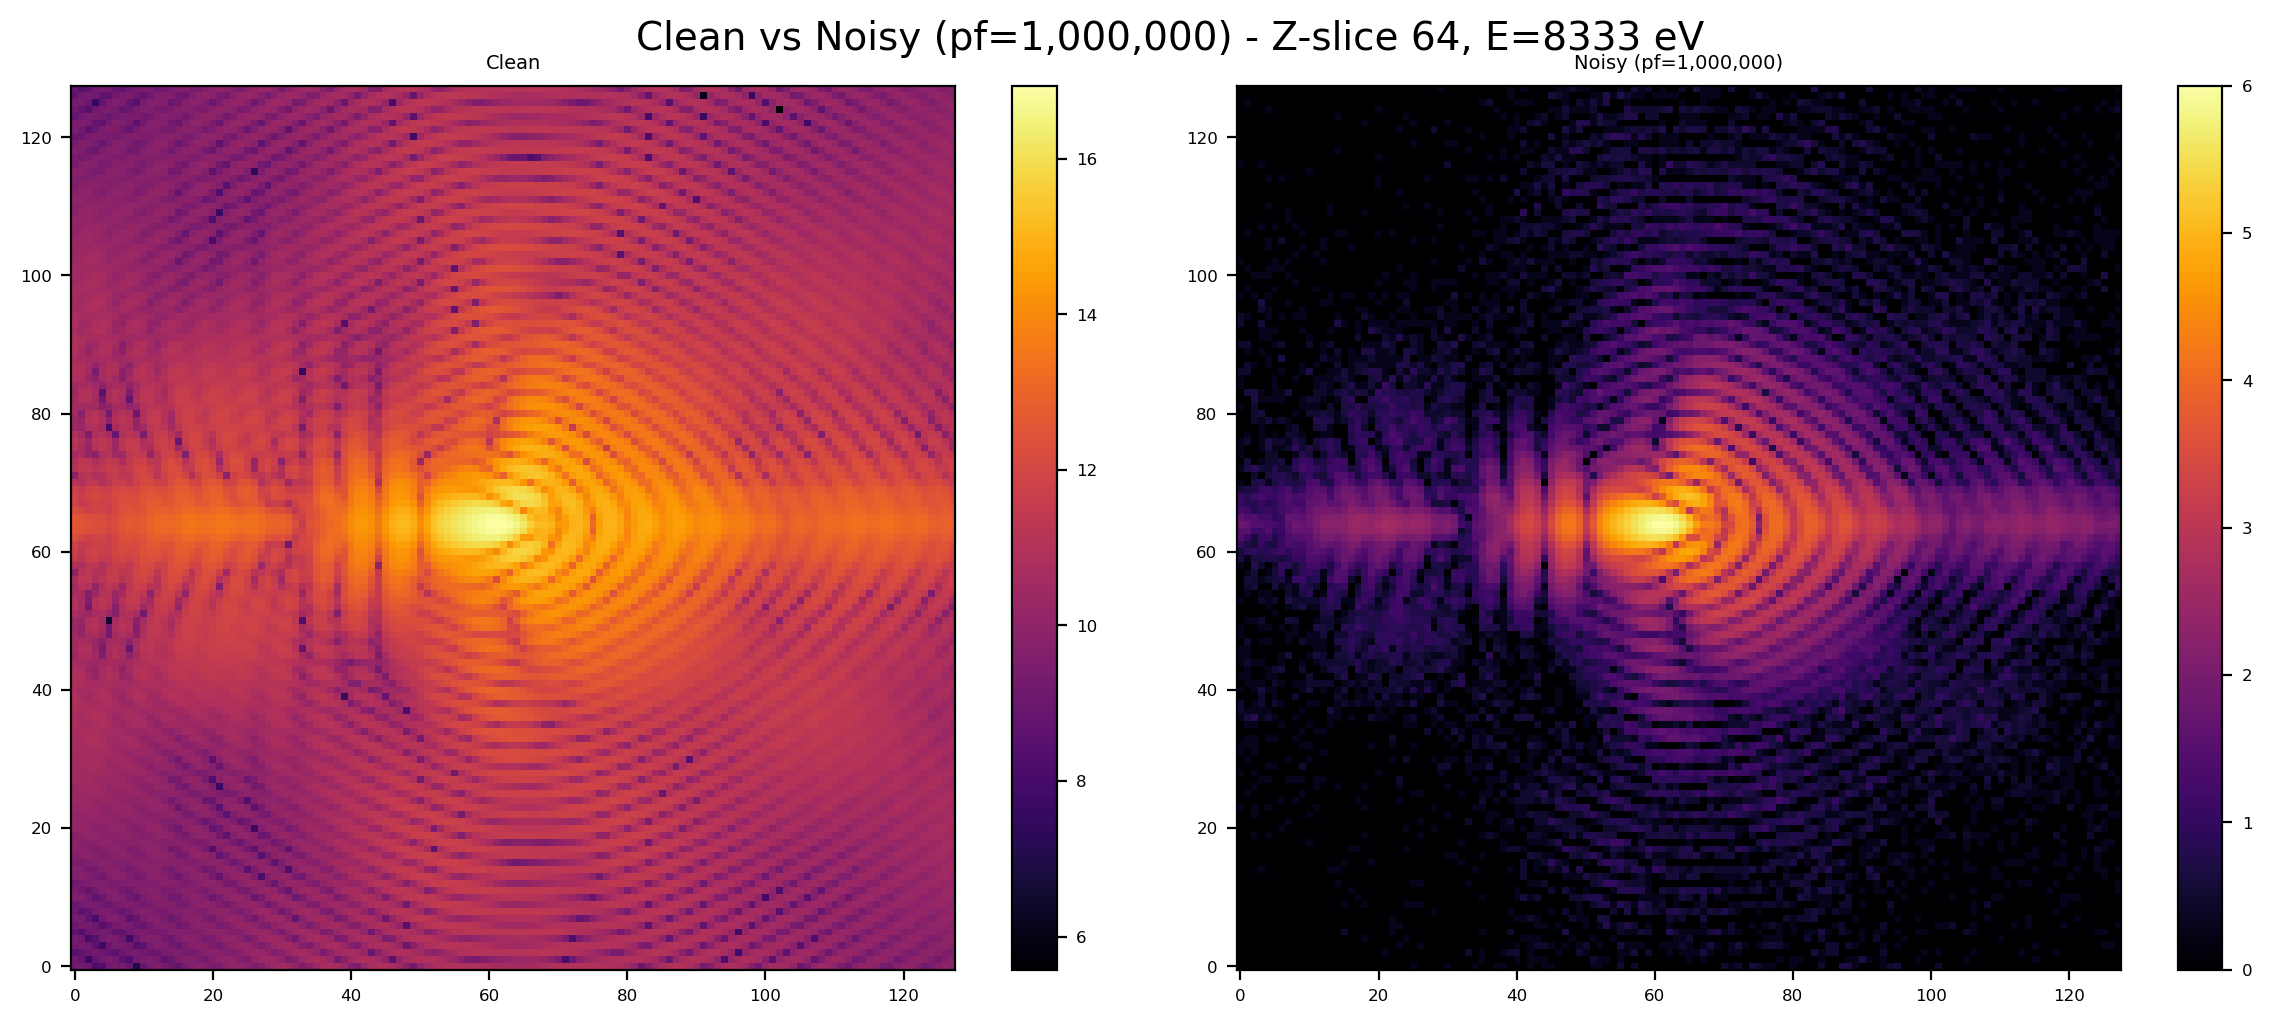


✓ 3D Noisy Dataset saved:
  /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6/test_intensity_3d_noise_pf1e6.npy
  /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6/test_energies.npy
  /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6/test_3d_noise_pf1e6_metadata.txt

Correlation with clean data: 0.9959

Ready for inference with:
  python run_inference_3d.py -c checkpoint.pt --intensity /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6/test_intensity_3d_noise_pf1e6.npy --energies /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6/test_energies.npy -o output/


In [39]:
# # %% Ran afternoon of 09/12/25
# # =============================================================================
# # GENERATE 3D NOISY TEST DATA (pf1e6)
# # =============================================================================
# # Adds Poisson noise to the 3D diffraction volumes

# import numpy as np
# from pathlib import Path

# POISSON_FACTOR = 1000000  # 1e6

# print(f"Generating 3D noisy test dataset with Poisson factor = {POISSON_FACTOR:,}")
# print("=" * 60)

# # Apply Poisson noise to each 3D diffraction pattern
# noisy_diff_patterns = {}

# for energy in CNN_ENERGIES:
#     data = diff_patterns[energy]
    
#     data_normalized = POISSON_FACTOR * data / np.max(data)
#     data_noise = np.random.poisson(data_normalized)
    
#     noisy_diff_patterns[energy] = data_noise
    
#     snr = data.sum() / np.sqrt(data_noise.sum())
#     print(f"  E = {energy} eV: max_clean = {data.max():.2e}, "
#           f"max_noisy = {data_noise.max():.2e}, SNR ≈ {snr:.1f}")

# print("\n✓ Poisson noise applied to all 3D patterns")


# # %%
# # Crop noisy patterns to 128×128×128 and stack
# # --------------------------------------------
# print(f"\nCropping noisy patterns to {OUTPUT_SIZE}×{OUTPUT_SIZE}×{OUTPUT_SIZE}...")

# cropped_noisy_volumes = {}
# for energy in CNN_ENERGIES:
#     full_shape = noisy_diff_patterns[energy].shape
    
#     starts = [(s - OUTPUT_SIZE) // 2 for s in full_shape]
#     ends = [start + OUTPUT_SIZE for start in starts]
    
#     cropped_noisy_volumes[energy] = noisy_diff_patterns[energy][
#         starts[0]:ends[0],
#         starts[1]:ends[1],
#         starts[2]:ends[2]
#     ]

# # Stack into (D, H, W, E) format
# noisy_intensity_3d = np.stack([cropped_noisy_volumes[E] for E in CNN_ENERGIES], axis=-1)

# print(f"\n✓ Created 3D noisy intensity array")
# print(f"  Shape: {noisy_intensity_3d.shape}")
# print(f"  Value range: [{noisy_intensity_3d.min():.2e}, {noisy_intensity_3d.max():.2e}]")


# # %%
# # Visualize comparison: clean vs noisy (central slice)
# # ----------------------------------------------------
# import matplotlib.pyplot as plt

# z_center = OUTPUT_SIZE // 2
# e_idx = 4  # Pick energy near K-edge

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# fig.suptitle(f'Clean vs Noisy (pf={POISSON_FACTOR:,}) - Z-slice {z_center}, E={CNN_ENERGIES[e_idx]} eV', fontsize=14)

# im0 = axes[0].imshow(np.log10(intensity_3d[z_center, :, :, e_idx] + 1), cmap='inferno', origin='lower')
# axes[0].set_title('Clean')
# plt.colorbar(im0, ax=axes[0])

# im1 = axes[1].imshow(np.log10(noisy_intensity_3d[z_center, :, :, e_idx] + 1), cmap='inferno', origin='lower')
# axes[1].set_title(f'Noisy (pf={POISSON_FACTOR:,})')
# plt.colorbar(im1, ax=axes[1])

# plt.tight_layout()
# plt.show()


# # %%
# # Save 3D noisy test dataset
# # --------------------------
# save_dir = Path("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6")
# save_dir.mkdir(parents=True, exist_ok=True)

# # Save 3D noisy intensity
# intensity_file = save_dir / "test_intensity_3d_noise_pf1e6.npy"
# np.save(intensity_file, noisy_intensity_3d.astype(np.float32))

# # Save energies
# energies_file = save_dir / "test_energies.npy"
# np.save(energies_file, CNN_ENERGIES)

# # Save metadata
# metadata_file = save_dir / "test_3d_noise_pf1e6_metadata.txt"
# with open(metadata_file, 'w') as f:
#     f.write("NanoMAD CNN 3D Test Dataset - Noisy (pf1e6)\n")
#     f.write("=" * 50 + "\n\n")
#     f.write(f"Poisson factor: {POISSON_FACTOR:,}\n\n")
#     f.write(f"Intensity data shape: {noisy_intensity_3d.shape}\n")
#     f.write(f"Format: (D, H, W, E) = (depth, height, width, energies)\n")
#     f.write(f"Volume size: {OUTPUT_SIZE}×{OUTPUT_SIZE}×{OUTPUT_SIZE}\n")
#     f.write(f"N_energies: {len(CNN_ENERGIES)}\n\n")
#     f.write(f"Energies (eV): {CNN_ENERGIES.tolist()}\n")
#     f.write(f"Data type: {noisy_intensity_3d.dtype}\n")
#     f.write(f"Value range: [{noisy_intensity_3d.min():.2e}, {noisy_intensity_3d.max():.2e}]\n\n")
#     f.write(f"Particle info:\n")
#     f.write(f"  Fe atoms (core): {Fe_positions.shape[1]}\n")
#     f.write(f"  Ni atoms (shell): {Ni_positions.shape[1]}\n")
#     f.write(f"  Bragg peak: {hkl}\n")

# print("\n✓ 3D Noisy Dataset saved:")
# print(f"  {intensity_file}")
# print(f"  {energies_file}")
# print(f"  {metadata_file}")

# # Sanity check
# correlation = np.corrcoef(intensity_3d.flatten(), noisy_intensity_3d.flatten())[0, 1]
# print(f"\nCorrelation with clean data: {correlation:.4f}")

# print(f"\nReady for inference with:")
# print(f"  python run_inference_3d.py -c checkpoint.pt --intensity {intensity_file} --energies {energies_file} -o output/")

GENERATING 3D CNN TEST DATA
Energies: [8313, 8318, 8323, 8328, 8333, 8338, 8343, 8348] eV
Output size: 128³

 Done. Shape: (128, 128, 128), Peak: 1.13e+17
 Done. Shape: (128, 128, 128), Peak: 1.09e+17
 Done. Shape: (128, 128, 128), Peak: 1.04e+17
 Done. Shape: (128, 128, 128), Peak: 9.32e+16
 Done. Shape: (128, 128, 128), Peak: 8.73e+16
 Done. Shape: (128, 128, 128), Peak: 1.01e+17
 Done. Shape: (128, 128, 128), Peak: 1.11e+17
 Done. Shape: (128, 128, 128), Peak: 1.16e+17

✓ All 8 diffraction patterns computed

Cropping to 128×128×128...
  Original: (128, 128, 128)
  Cropped:  (128, 128, 128)

✓ Clean 3D array: (128, 128, 128, 8)
  Range: [5.28e+03, 1.16e+17]

✓ Clean data saved to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean_v2

Adding Poisson noise (factor = 1,000,000)...
✓ Noisy 3D array: (128, 128, 128, 8)
  Range: [0.00e+00, 1.00e+06]
  Correlation with clean: 0.9959

✓ Noisy data saved to: /data/id01/inhouse/tsarrazin/Concentration/NanoMAD 

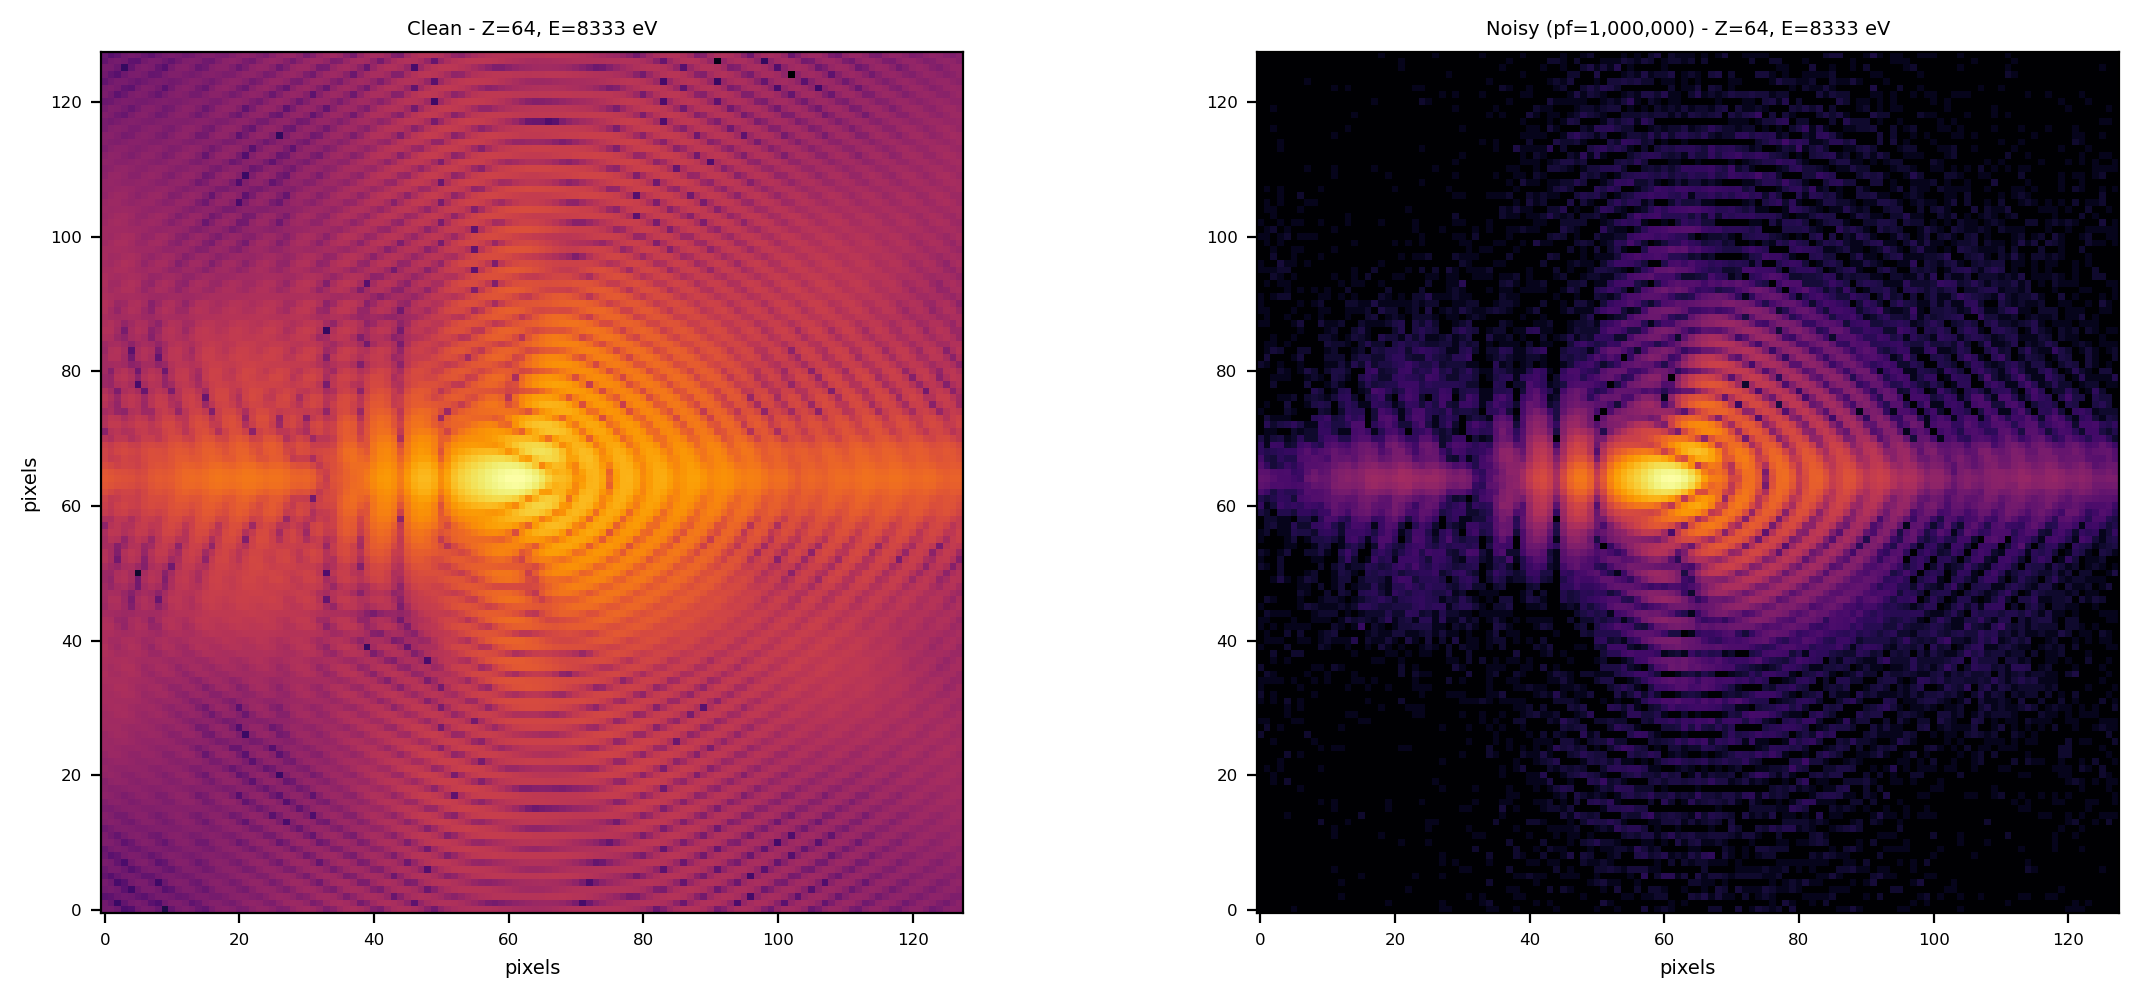


READY FOR INFERENCE

Clean data:
  python run_inference_3d.py -c checkpoint.pt \
      --intensity "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean_v2/test_intensity_3d.npy" \
      --energies "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean_v2/test_energies.npy" \
      -o "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean_v2/results/"

Noisy data:
  python run_inference_3d.py -c checkpoint.pt \
      --intensity "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6_v2/test_intensity_3d_noise_pf1e6.npy" \
      --energies "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6_v2/test_energies.npy" \
      -o "/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6_v2/results/"


In [15]:
# =============================================================================
# GENERATE 3D MULTI-ENERGY DIFFRACTION VOLUMES FOR CNN (8 energies)
# =============================================================================
# Adapts your existing simulation code to produce (128, 128, 128, 8) output
# =============================================================================

import os
import numpy as np
from pathlib import Path

# -------- CONFIG --------
E0 = 8333.0  # Ni K-edge
CNN_ENERGIES = np.array([8313, 8318, 8323, 8328, 8333, 8338, 8343, 8348])  # eV
OUTPUT_SIZE = 128  # Crop to this size

POISSON_FACTOR = 1_000_000  # 1e6 for low noise (set to None for clean data)

# Output paths
# /data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean
save_dir_clean = Path("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_clean_v2")
save_dir_noisy = Path("/data/id01/inhouse/tsarrazin/Concentration/NanoMAD ML/evaluation_data/test_3d_noise_pf1e6_v2")

print("=" * 60)
print("GENERATING 3D CNN TEST DATA")
print("=" * 60)
print(f"Energies: {CNN_ENERGIES.tolist()} eV")
print(f"Output size: {OUTPUT_SIZE}³")
print()

# -------- COMPUTE DIFFRACTION AT EACH ENERGY --------
diff_patterns = {}

for i, energy in enumerate(CNN_ENERGIES):
    print(f"[{i+1}/{len(CNN_ENERGIES)}] E = {energy} eV ...", end='', flush=True)
    
    # Your existing function - computes on fixed qx, qy, qz grid
    full_scattered_amp = energy_dependent_scattered_amp(
        qx, qy, qz,
        (Fe_positions, scat_factors["Fe"]["full"]),
        (Ni_positions, scat_factors["Ni"]["full"]),
        energy=energy
    )
    
    I_clean = np.abs(full_scattered_amp) ** 2
    diff_patterns[energy] = I_clean
    
    print(f" Done. Shape: {I_clean.shape}, Peak: {I_clean.max():.2e}")

print("\n✓ All 8 diffraction patterns computed")


# -------- CROP TO 128×128×128 --------
print(f"\nCropping to {OUTPUT_SIZE}×{OUTPUT_SIZE}×{OUTPUT_SIZE}...")

cropped_clean = {}
full_shape = diff_patterns[CNN_ENERGIES[0]].shape
starts = [(s - OUTPUT_SIZE) // 2 for s in full_shape]
ends = [start + OUTPUT_SIZE for start in starts]

for energy in CNN_ENERGIES:
    cropped_clean[energy] = diff_patterns[energy][
        starts[0]:ends[0],
        starts[1]:ends[1],
        starts[2]:ends[2]
    ]

print(f"  Original: {full_shape}")
print(f"  Cropped:  {cropped_clean[CNN_ENERGIES[0]].shape}")


# -------- STACK INTO (D, H, W, E) FORMAT --------
intensity_3d_clean = np.stack([cropped_clean[E] for E in CNN_ENERGIES], axis=-1).astype(np.float32)

print(f"\n✓ Clean 3D array: {intensity_3d_clean.shape}")
print(f"  Range: [{intensity_3d_clean.min():.2e}, {intensity_3d_clean.max():.2e}]")


# -------- SAVE CLEAN DATA --------
save_dir_clean.mkdir(parents=True, exist_ok=True)
np.save(save_dir_clean / "test_intensity_3d.npy", intensity_3d_clean)
np.save(save_dir_clean / "test_energies.npy", CNN_ENERGIES)

print(f"\n✓ Clean data saved to: {save_dir_clean}")


# -------- ADD POISSON NOISE (if requested) --------
if POISSON_FACTOR is not None:
    print(f"\nAdding Poisson noise (factor = {POISSON_FACTOR:,})...")
    
    cropped_noisy = {}
    for energy in CNN_ENERGIES:
        I_clean = cropped_clean[energy]
        I_max = I_clean.max() if I_clean.max() > 0 else 1.0
        
        # Poisson sampling
        counts = np.random.poisson(POISSON_FACTOR * I_clean / I_max)
        cropped_noisy[energy] = counts.astype(np.float32)
    
    # Stack
    intensity_3d_noisy = np.stack([cropped_noisy[E] for E in CNN_ENERGIES], axis=-1).astype(np.float32)
    
    print(f"✓ Noisy 3D array: {intensity_3d_noisy.shape}")
    print(f"  Range: [{intensity_3d_noisy.min():.2e}, {intensity_3d_noisy.max():.2e}]")
    
    # Save
    save_dir_noisy.mkdir(parents=True, exist_ok=True)
    np.save(save_dir_noisy / "test_intensity_3d_noise_pf1e6.npy", intensity_3d_noisy)
    np.save(save_dir_noisy / "test_energies.npy", CNN_ENERGIES)
    
    # Correlation check
    corr = np.corrcoef(intensity_3d_clean.flatten(), intensity_3d_noisy.flatten())[0, 1]
    print(f"  Correlation with clean: {corr:.4f}")
    print(f"\n✓ Noisy data saved to: {save_dir_noisy}")


# -------- VISUALIZATION --------
import matplotlib.pyplot as plt

z_center = OUTPUT_SIZE // 2
e_idx = 4  # Energy index for K-edge (8333 eV)

fig, axes = plt.subplots(1, 2 if POISSON_FACTOR else 1, figsize=(12 if POISSON_FACTOR else 6, 5))
if POISSON_FACTOR is None:
    axes = [axes]

axes[0].imshow(np.log10(intensity_3d_clean[z_center, :, :, e_idx] + 1), cmap='inferno', origin='lower')
axes[0].set_title(f'Clean - Z={z_center}, E={CNN_ENERGIES[e_idx]} eV')
axes[0].set_xlabel('pixels')
axes[0].set_ylabel('pixels')

if POISSON_FACTOR:
    axes[1].imshow(np.log10(intensity_3d_noisy[z_center, :, :, e_idx] + 1), cmap='inferno', origin='lower')
    axes[1].set_title(f'Noisy (pf={POISSON_FACTOR:,}) - Z={z_center}, E={CNN_ENERGIES[e_idx]} eV')
    axes[1].set_xlabel('pixels')

plt.tight_layout()
plt.show()


# -------- PRINT INFERENCE COMMANDS --------
print("\n" + "=" * 60)
print("READY FOR INFERENCE")
print("=" * 60)
print("\nClean data:")
print(f"  python run_inference_3d.py -c checkpoint.pt \\")
print(f"      --intensity \"{save_dir_clean}/test_intensity_3d.npy\" \\")
print(f"      --energies \"{save_dir_clean}/test_energies.npy\" \\")
print(f"      -o \"{save_dir_clean}/results/\"")

if POISSON_FACTOR:
    print("\nNoisy data:")
    print(f"  python run_inference_3d.py -c checkpoint.pt \\")
    print(f"      --intensity \"{save_dir_noisy}/test_intensity_3d_noise_pf1e6.npy\" \\")
    print(f"      --energies \"{save_dir_noisy}/test_energies.npy\" \\")
    print(f"      -o \"{save_dir_noisy}/results/\"")